# Bimodal Gaussians

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import os
import sys

from scipy.stats import multivariate_normal

In [2]:
# IMPORT Z SPACE DATA

catalog_name = 'SculptorInSextans'

path = catalog_name+'_8deg/'
savepath = path+'Figaro_outputs/'

if not os.path.exists(savepath):
    os.makedirs(savepath)

z_train = pd.read_csv(path+catalog_name+'_z_train_region.csv')
z_train = z_train.drop(columns=['Unnamed: 0'])

X_test = pd.read_csv(path+catalog_name+'_X_test_4deg_region.csv')
z_test = pd.read_csv(path+catalog_name+'_z_test_4deg_region.csv')
z_test = z_test.drop(columns=['Unnamed: 0'])
z_test.head(10)

# THEORETICAL NORMALIZED GAUSSIAN DISTRIBUTION
mean = 0
std_dev = 1
norm_train = np.linspace(-5, 5, z_train.shape[0])
norm_test = np.linspace(-5, 5, z_test.shape[0])
y_norm_train = multivariate_normal.pdf(norm_train, mean, std_dev)
y_norm_test = multivariate_normal.pdf(norm_test, mean, std_dev)

z_test.head()

,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,pmra_pmdec_corr,phot_g_mean_mag_err,phot_bp_mean_mag_err
0,42,0.506135,0.511146,-0.270796,1.489784,0.235262,-0.643772,0.046005,0.047857,0.306743,-0.367,0.011499,0.021656
1,42,0.492262,0.507918,-0.270781,1.462612,0.251180,-0.749792,0.044330,0.050151,0.306636,-0.367,0.010303,0.021047
2,42,0.513604,0.516493,0.660488,2.113044,0.228475,-0.173899,0.127675,0.116830,0.317555,-0.367,0.057223,0.059695
3,42,0.525653,0.504465,0.165351,1.523946,-0.620829,0.442608,0.154806,0.133301,0.318696,-0.367,0.076125,0.073138
4,42,0.513119,0.482172,-0.150709,-0.200669,-3.361919,0.777049,0.234914,0.229835,0.295862,-0.367,0.128198,0.077367


In [3]:
# TAKING THE MEMNBER INDICES
members_indices = np.where(z_test['source_id'] == 42)[0]
nonmembers_indices = np.where(z_test['source_id'] != 42)[0]

print('Number of members:', len(members_indices))
print('Number of non-members:', len(nonmembers_indices))

Number of members: 6354
Number of non-members: 52988


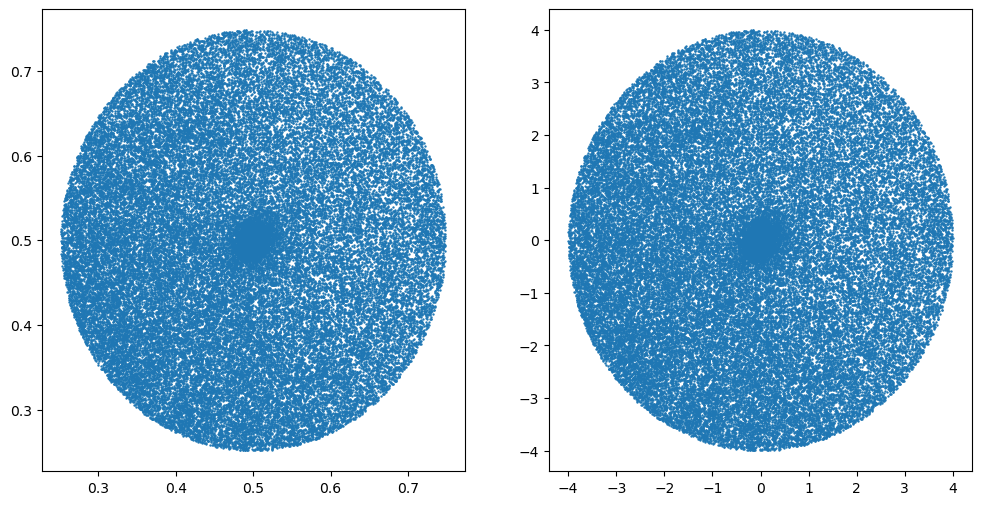

In [4]:
#check size of test set

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].scatter(z_test['Xi'], z_test['Xn'], s=0.5)
ax[1].scatter(X_test['Xi'], X_test['Xn'], s=0.5)

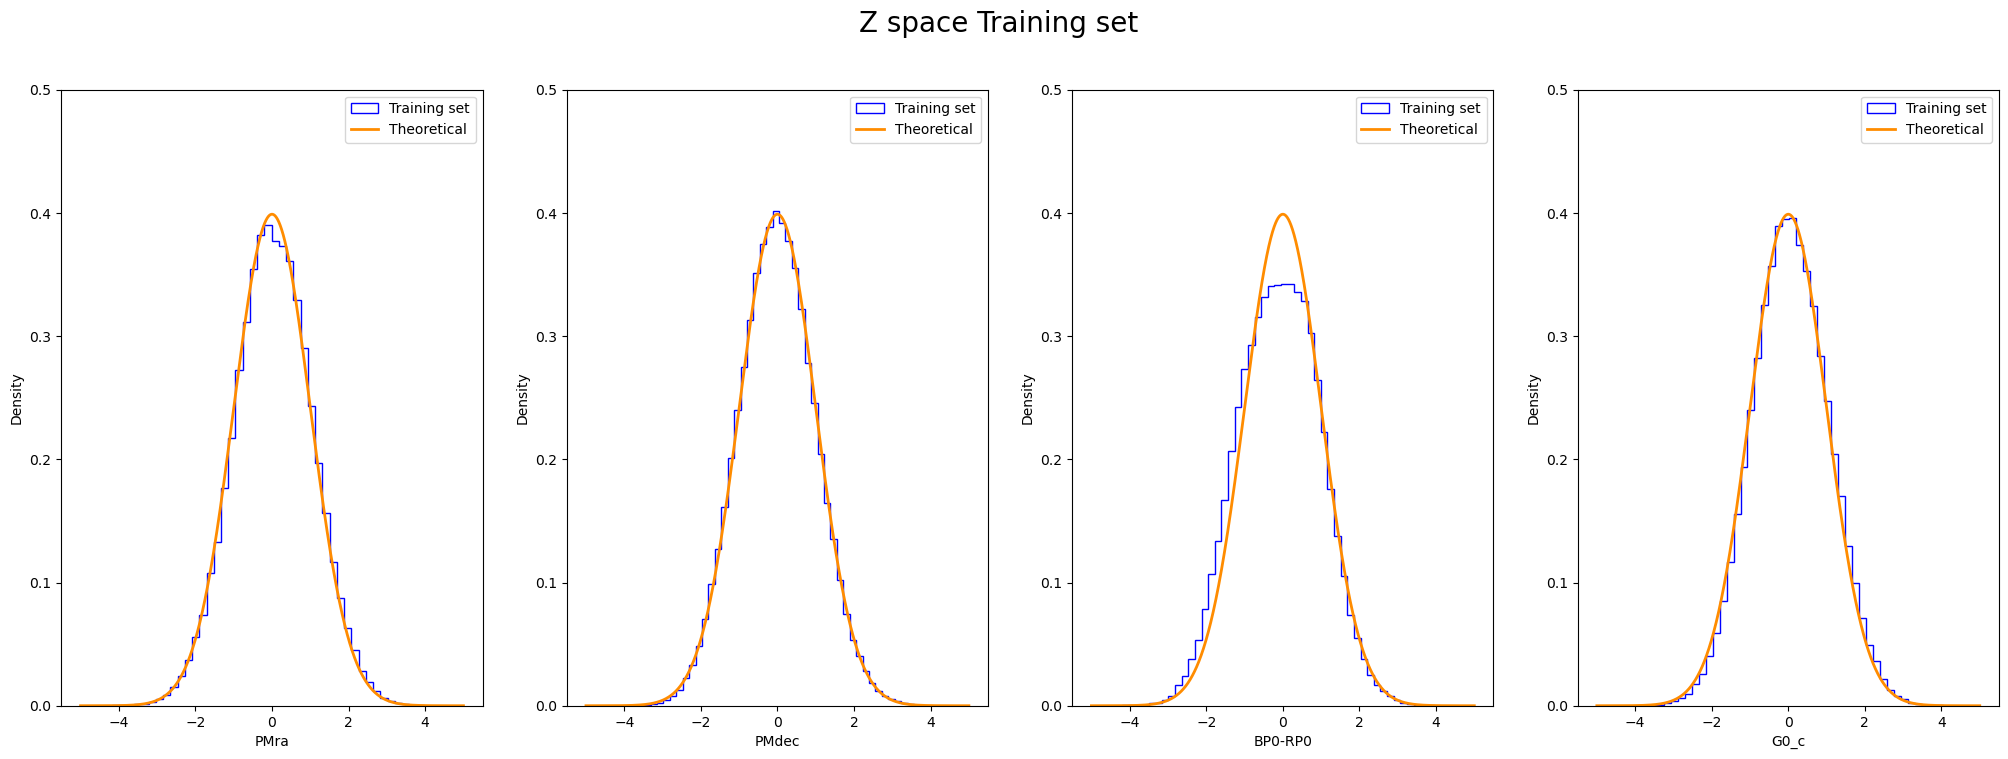

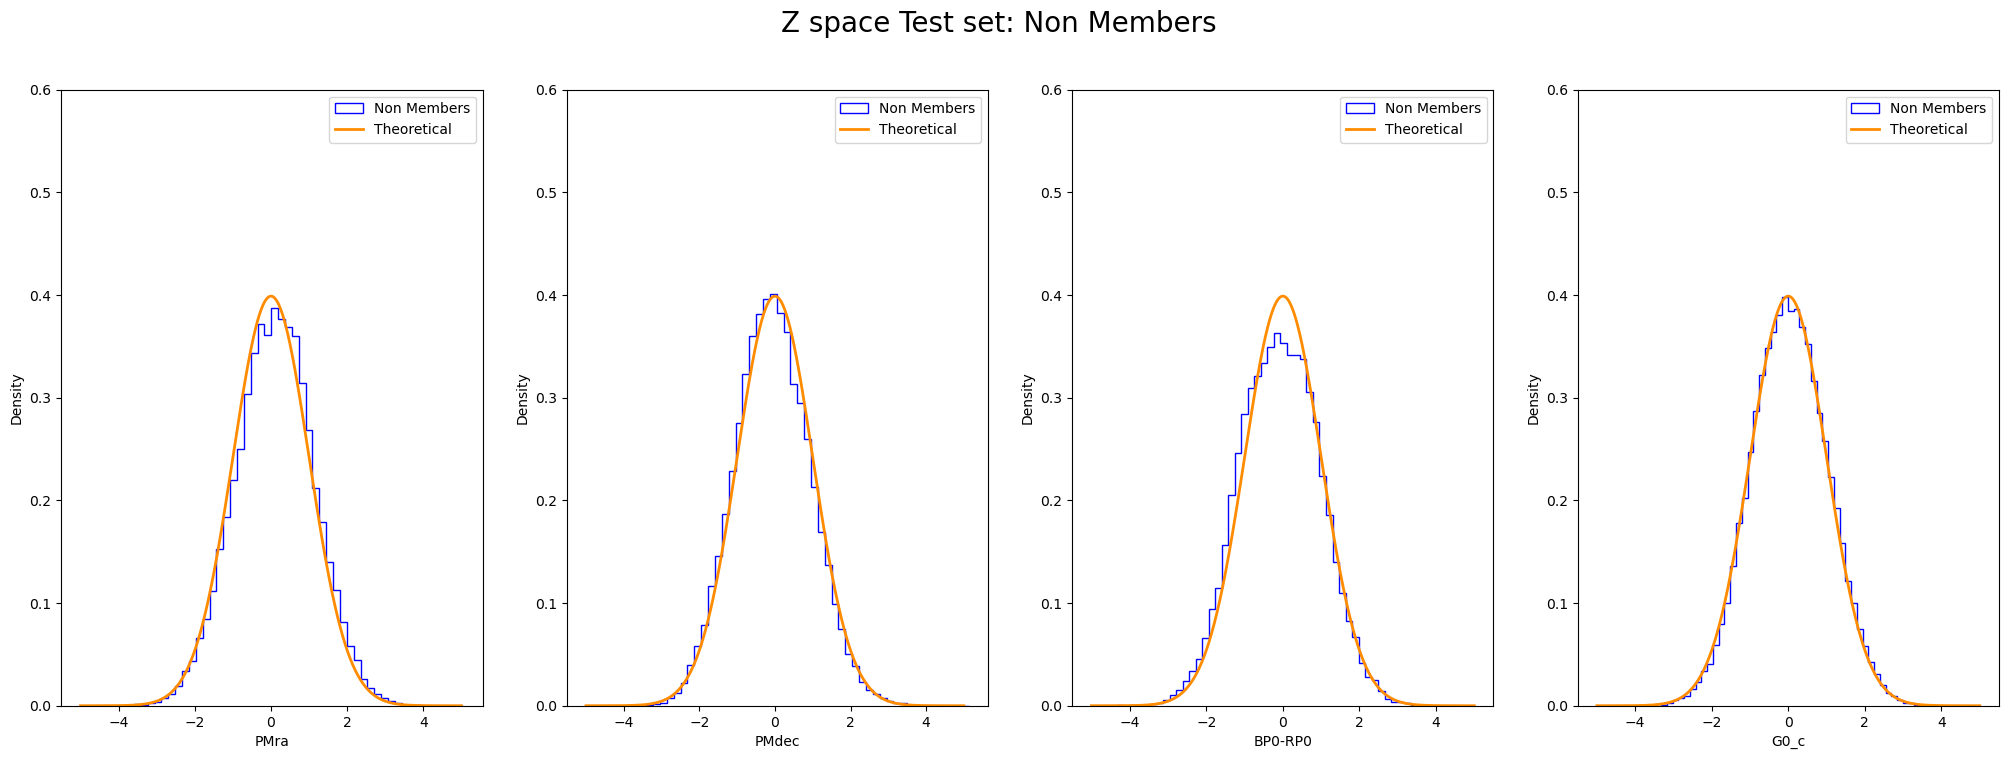

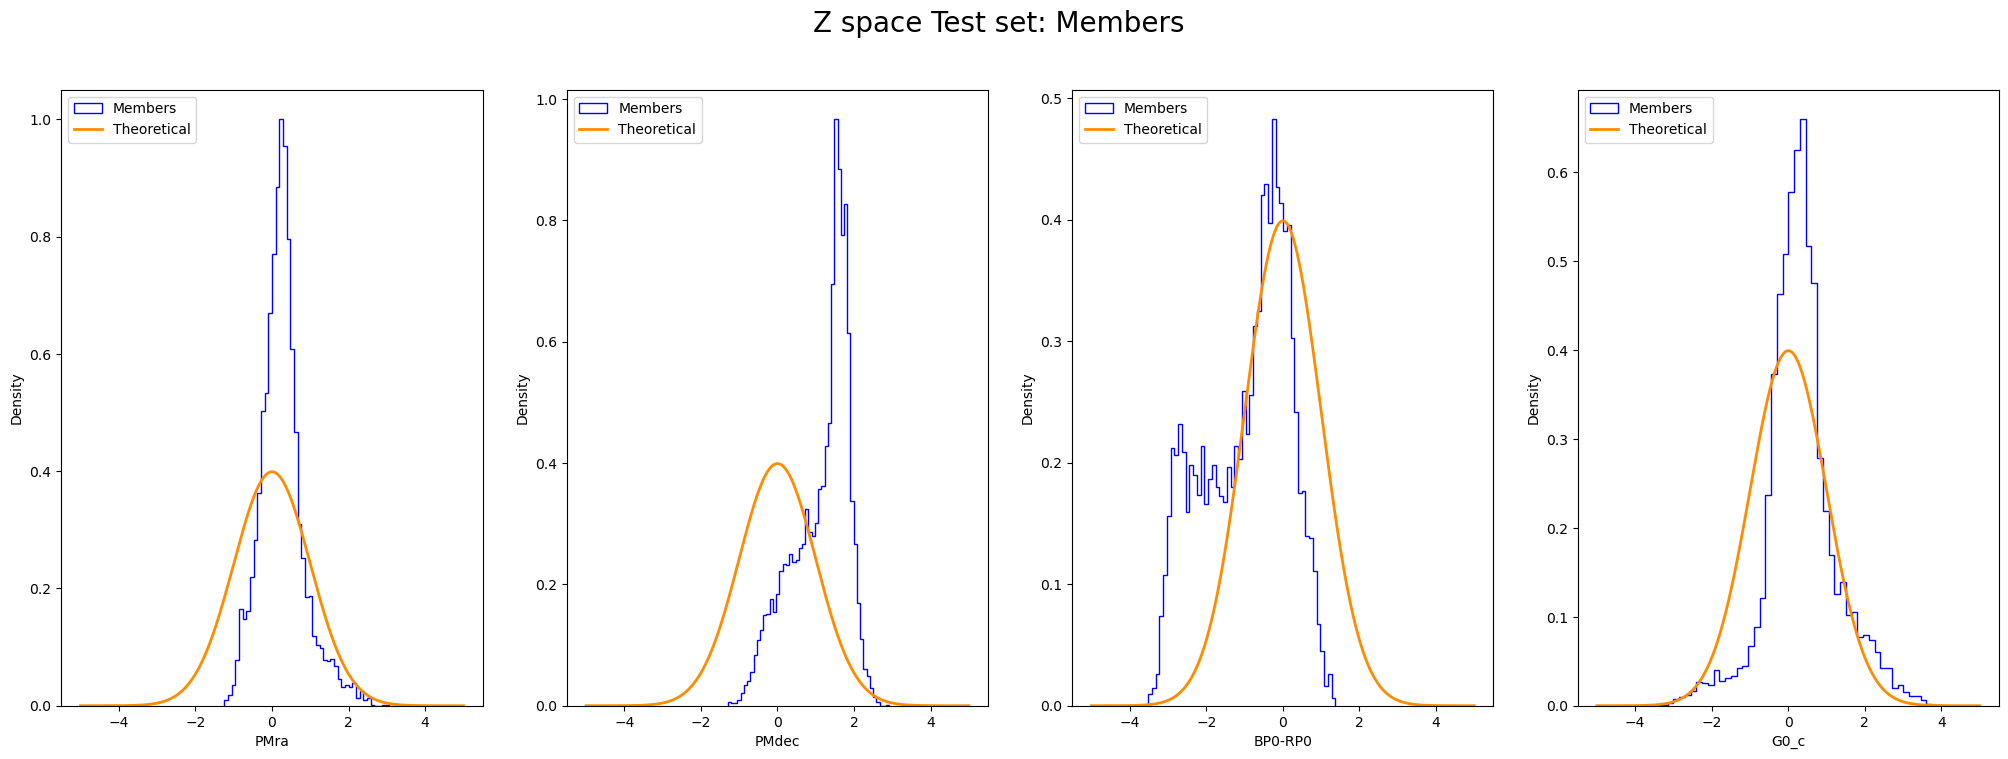

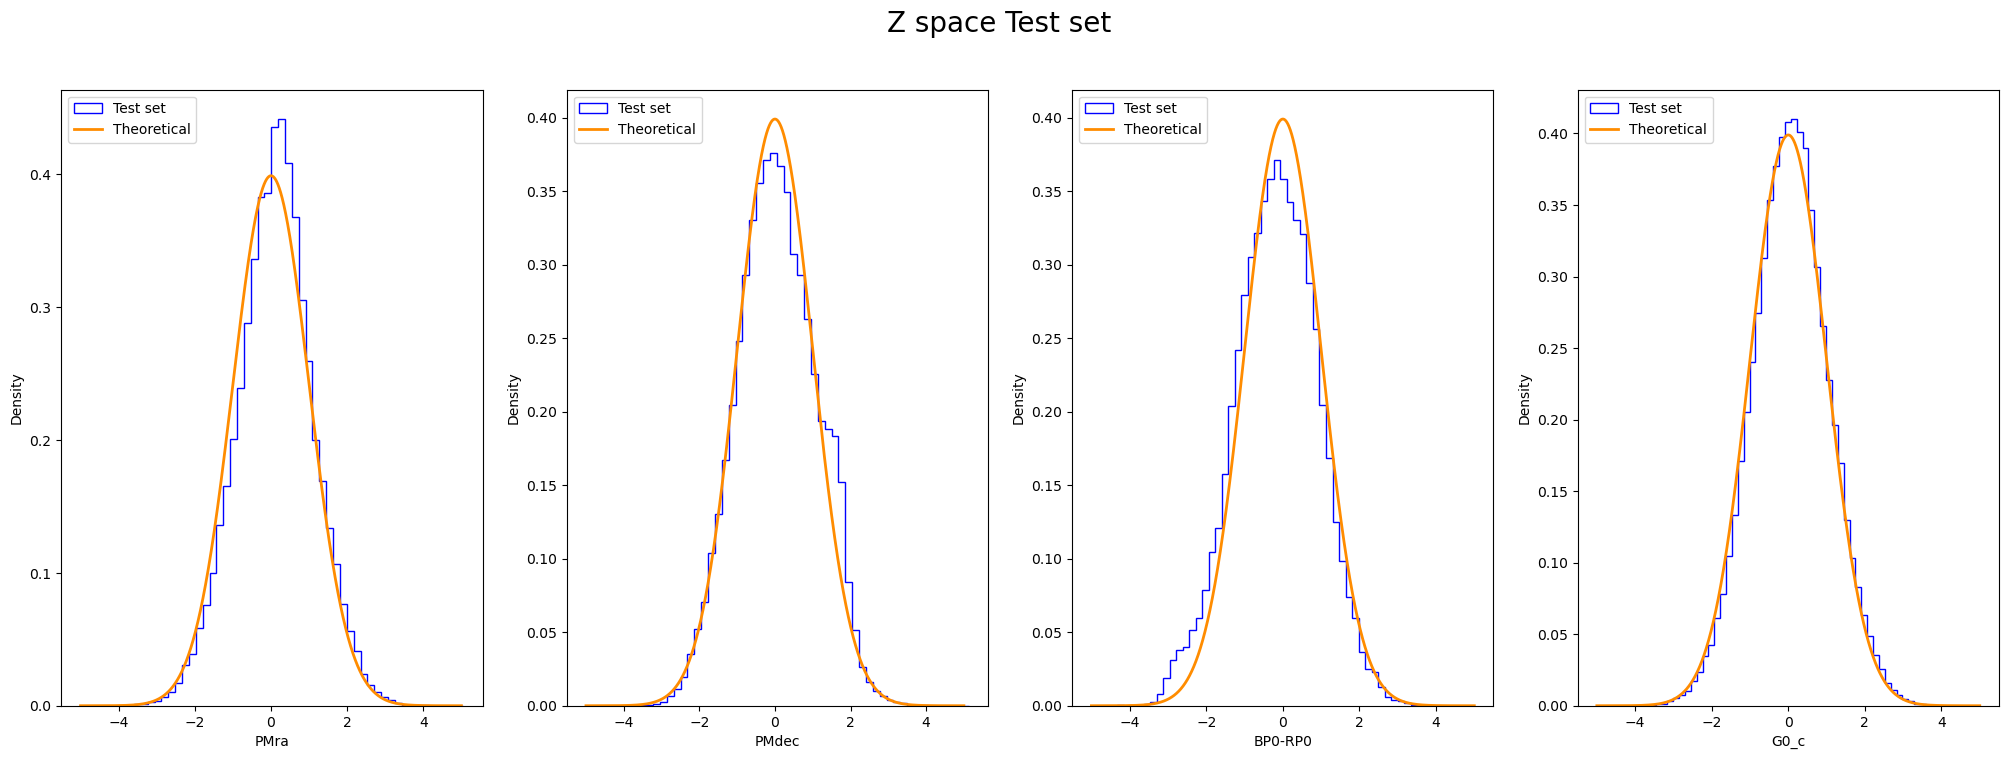

In [5]:
fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Training set', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_train.iloc[:,3+i], color='blue', label='Training set', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_train, y_norm_train, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_train.columns[3+i])
    plt.ylabel('Density')
    plt.ylim(0,0.5)
    plt.legend(loc='upper right')


fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set: Non Members', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test.iloc[nonmembers_indices,3+i], color='blue', label='Non Members', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test.columns[3+i])
    plt.ylabel('Density')
    plt.ylim(0,0.6)
    plt.legend(loc='upper right')


fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set: Members', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test.iloc[members_indices,3+i], color='blue', label='Members', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test.columns[3+i])
    plt.ylabel('Density')
    plt.legend(loc='upper left')

fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test.iloc[:,3+i], color='blue', label='Test set', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test.columns[3+i])
    plt.ylabel('Density')
    plt.legend(loc='upper left')

## let's clean with Mahalanobis

In [6]:
def mahalanobis_distance(df):
    
    delta_mu = np.vstack((df['PMra'].values, df['PMdec'].values)).T 
    #print(delta_mu.shape)
    
    # Covariance matrix from Gaia uncertainties and correlation
    errors_ra = df['pmra_error'].values
    errors_dec = df['pmdec_error'].values
    rho = 0.0 #df['pmra_pmdec_corr'].values     #  # Assuming no correlation for simplicity in case of mock data

    # Build covariance matrices: shape (N, 2, 2)
    cov_00 = errors_ra**2
    cov_11 = errors_dec**2
    cov_01 = rho * errors_ra * errors_dec

    cov_matrices = np.zeros((len(df), 2, 2))
    cov_matrices[:, 0, 0] = cov_00
    cov_matrices[:, 1, 1] = cov_11
    cov_matrices[:, 0, 1] = cov_01
    cov_matrices[:, 1, 0] = cov_01

    # Invert each 2x2 covariance matrix using a closed formula
    det = cov_00 * cov_11 - cov_01**2
    inv_cov = np.zeros_like(cov_matrices)

    inv_cov[:, 0, 0] =  cov_11 / det
    inv_cov[:, 1, 1] =  cov_00 / det
    inv_cov[:, 0, 1] = -cov_01 / det
    inv_cov[:, 1, 0] = -cov_01 / det

    # Now compute Mahalanobis distances
    # For each star: sqrt(Δ.T @ Σ⁻¹ @ Δ)
    md_squared = np.einsum('ni,nij,nj->n', delta_mu, inv_cov, delta_mu)
    mahalanobis_dist = np.sqrt(md_squared)

    
    return mahalanobis_dist

In [7]:
mahalanobis_cut = 5.0

X_test['mahalanobis_PM'] = mahalanobis_distance(X_test)

X_test_cut_indicies = X_test[(X_test['mahalanobis_PM'] < mahalanobis_cut)].index

print('Number of stars before Mahalanobis cut:', len(X_test))
print('members:', len(X_test[X_test['source_id'] == 42]))
print('non-members:', len(X_test[X_test['source_id'] != 42]))
print('')
print('Number of stars after Mahalanobis cut:', len(X_test_cut_indicies))
print('members:', len(X_test[X_test['source_id'] == 42][X_test['mahalanobis_PM'] < mahalanobis_cut]))
print('non-members:', len(X_test[X_test['source_id'] != 42][X_test['mahalanobis_PM'] < mahalanobis_cut]))

Number of stars before Mahalanobis cut: 59342
members: 6354
non-members: 52988

Number of stars after Mahalanobis cut: 25037
members: 6354
non-members: 18683


/var/folders/fc/nj7m75w92x73lf0kwtzgswxw0000gp/T/ipykernel_90817/676443284.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('members:', len(X_test[X_test['source_id'] == 42][X_test['mahalanobis_PM'] < mahalanobis_cut]))
/var/folders/fc/nj7m75w92x73lf0kwtzgswxw0000gp/T/ipykernel_90817/676443284.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('non-members:', len(X_test[X_test['source_id'] != 42][X_test['mahalanobis_PM'] < mahalanobis_cut]))


In [8]:
'''
z_test_cut = z_test.loc[X_test_cut_indicies].copy()
z_test_cut.reset_index(drop=True, inplace=True)

# TAKING AGAIN THE MEMNBER INDICES
members_indices = np.where(z_test_cut['source_id'] == 42)[0]
nonmembers_indices = np.where(z_test_cut['source_id'] != 42)[0]

print('Number of members:', len(members_indices))
print('Number of non-members:', len(nonmembers_indices))

#check size of test set

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].scatter(z_test['Xi'], z_test['Xn'], s=0.5)
ax[1].scatter(z_test_cut['Xi'], z_test_cut['Xn'], s=0.5)
'''

# Filter rows where 'source_id' is different from 42
non_members = z_test[z_test['source_id'] != 42]

# Select 40,000 rows to drop
rows_to_drop = non_members.sample(n=43000, random_state=42).index

# Drop the selected rows
z_test_cut = z_test.drop(index=rows_to_drop).reset_index(drop=True)

print(f"New shape of z_test: {z_test.shape}")

# TAKING THE MEMNBER INDICES
members_indices = np.where(z_test_cut['source_id'] == 42)[0]
nonmembers_indices = np.where(z_test_cut['source_id'] != 42)[0]

print('Number of members:', len(members_indices))
print('Number of non-members:', len(nonmembers_indices))

New shape of z_test: (59342, 13)
Number of members: 6354
Number of non-members: 9988


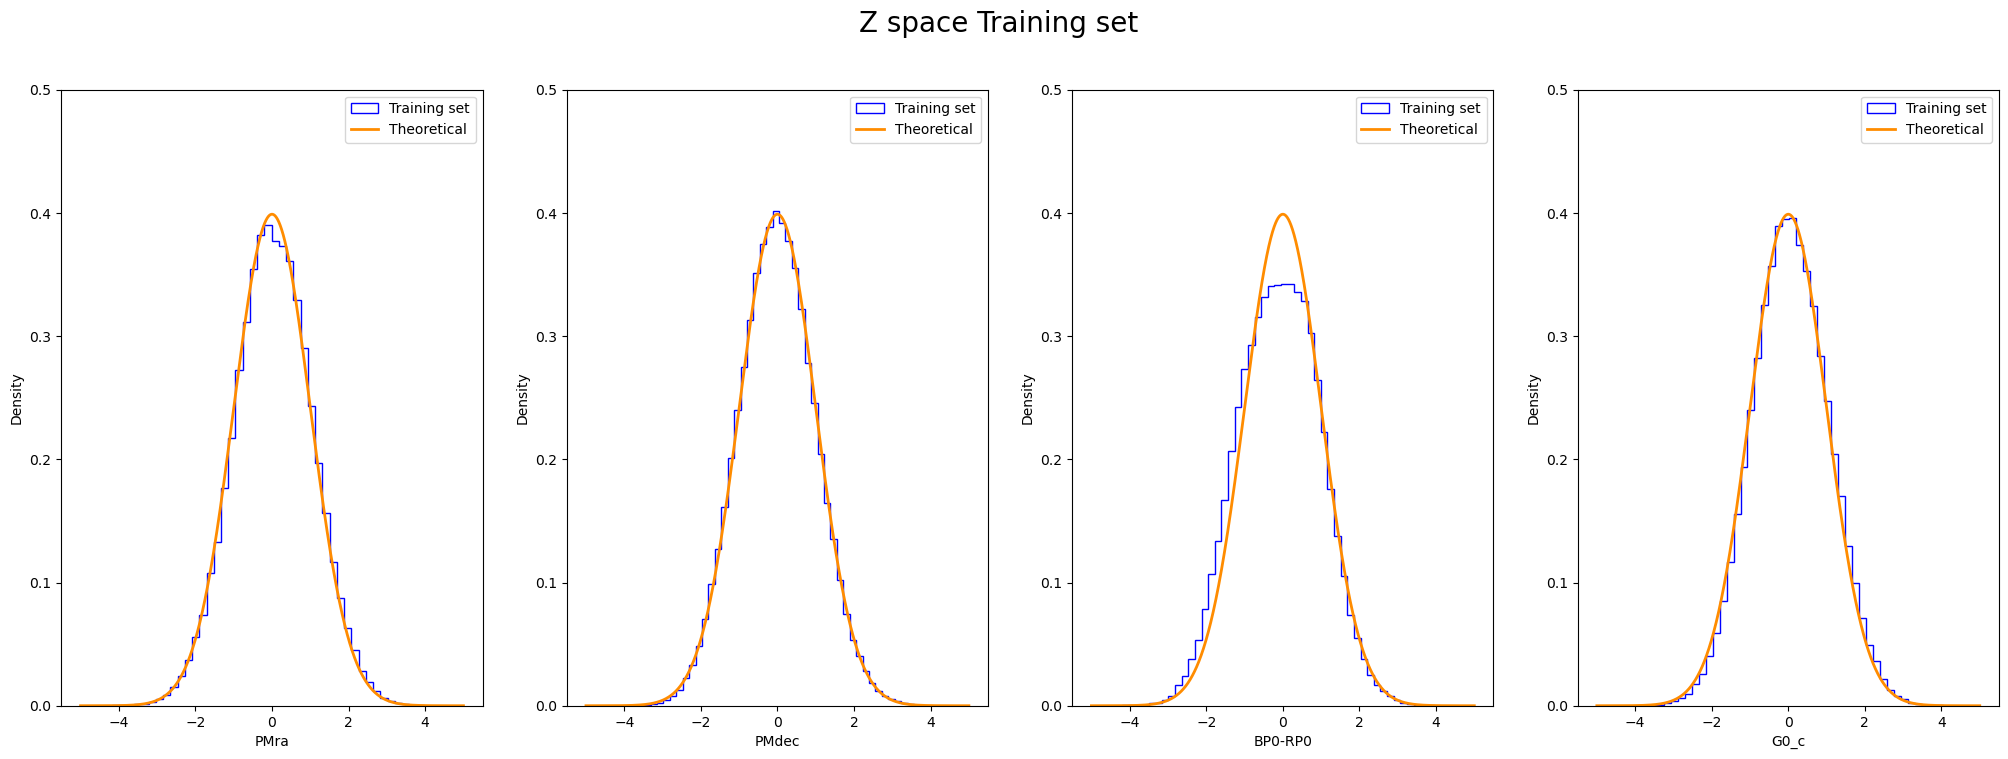

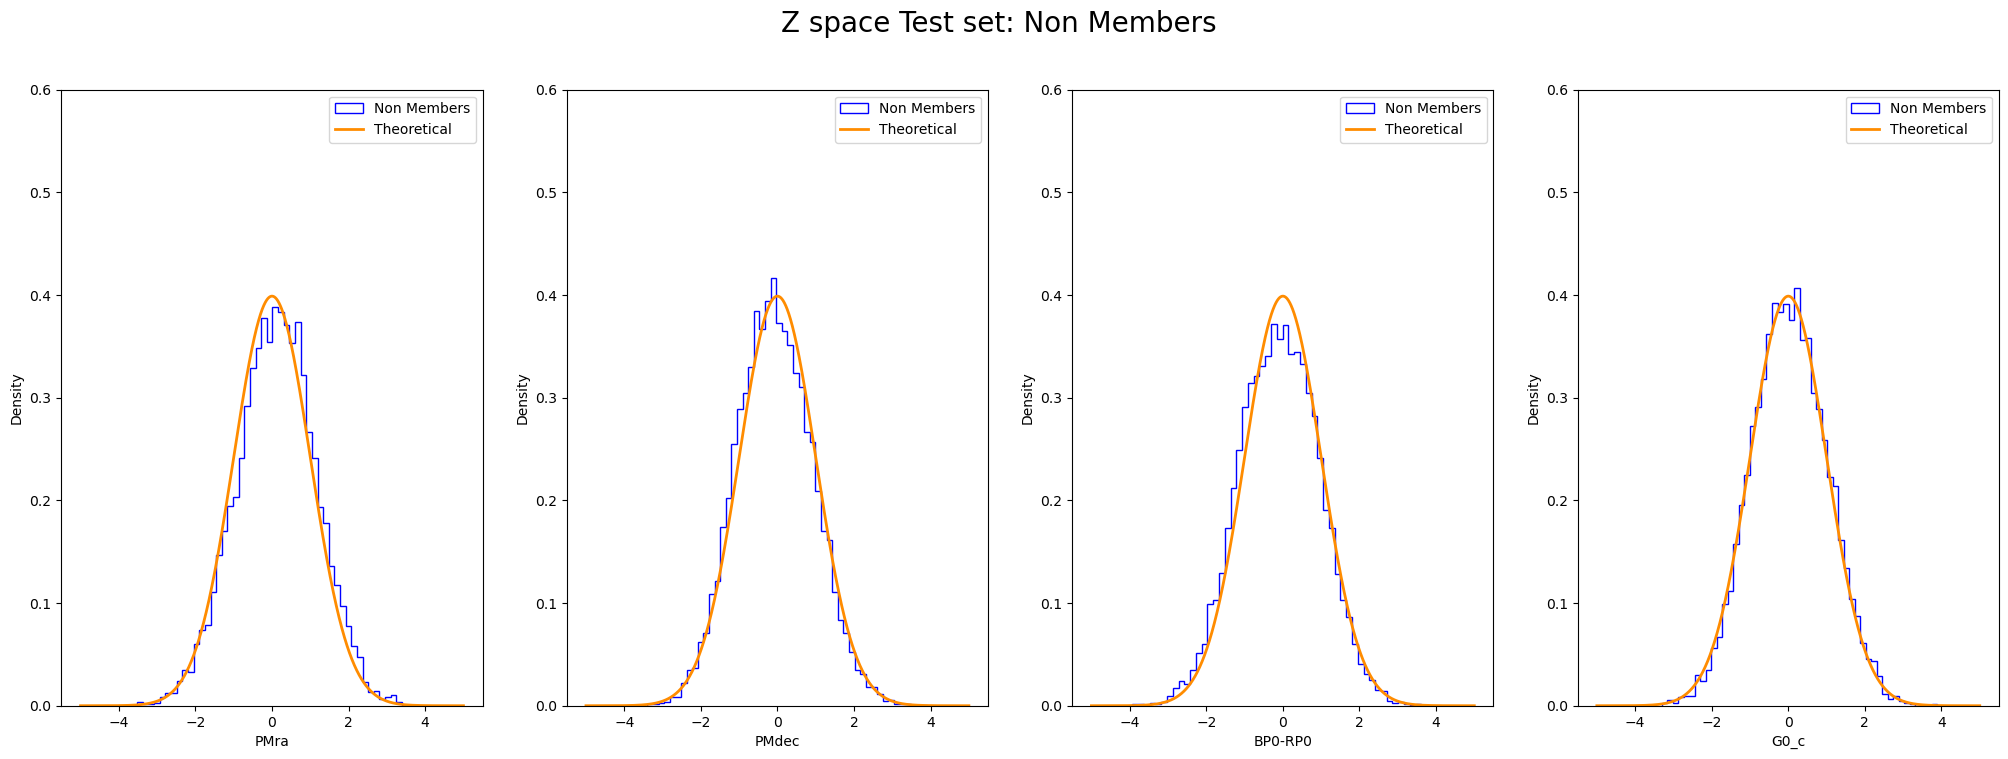

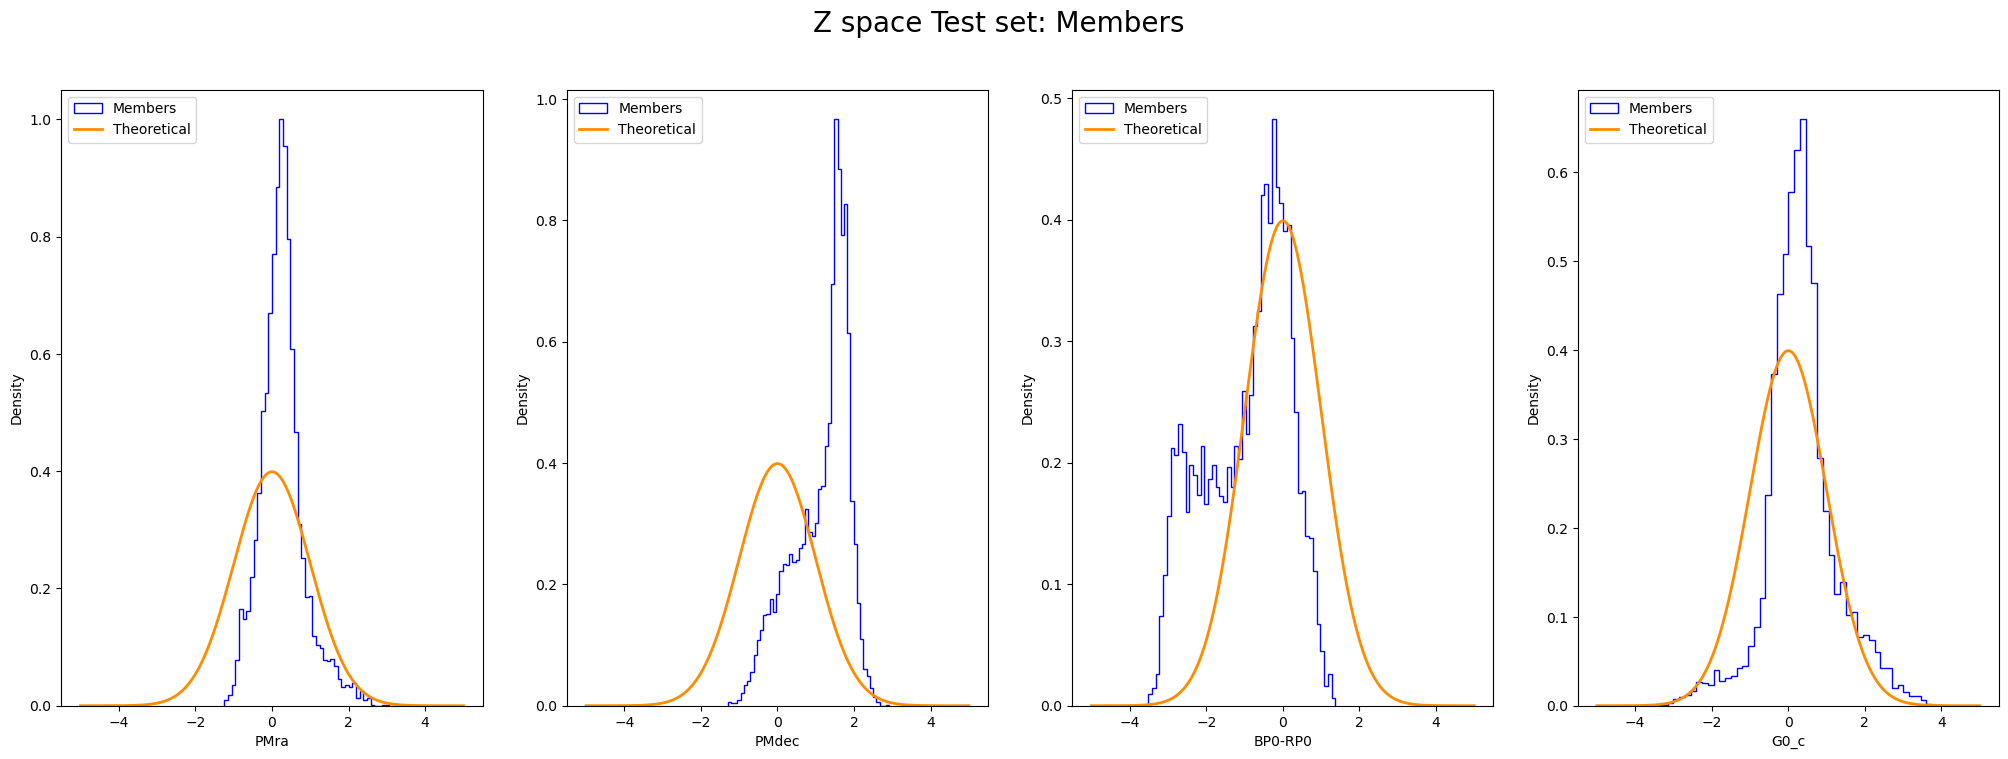

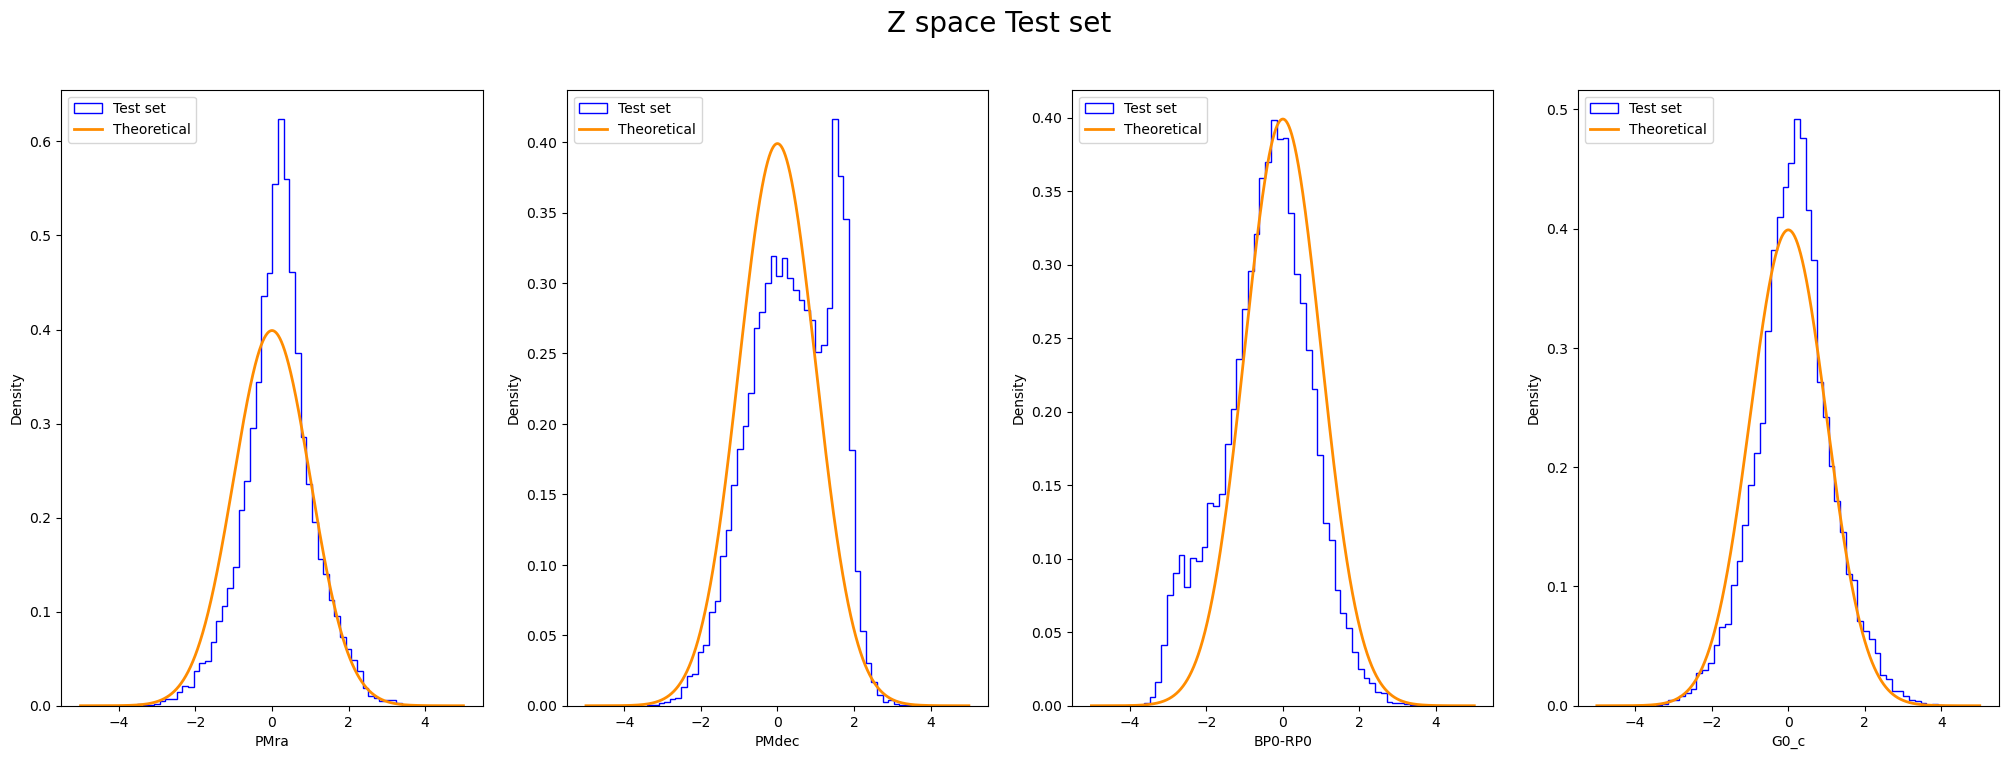

In [9]:
fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Training set', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_train.iloc[:,3+i], color='blue', label='Training set', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_train, y_norm_train, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_train.columns[3+i])
    plt.ylabel('Density')
    plt.ylim(0,0.5)
    plt.legend(loc='upper right')


fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set: Non Members', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test_cut.iloc[nonmembers_indices,3+i], color='blue', label='Non Members', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test_cut.columns[3+i])
    plt.ylabel('Density')
    plt.ylim(0,0.6)
    plt.legend(loc='upper right')


fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set: Members', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test_cut.iloc[members_indices,3+i], color='blue', label='Members', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test_cut.columns[3+i])
    plt.ylabel('Density')
    plt.legend(loc='upper left')

fig = plt.figure(figsize=(25,8))
fig.suptitle('Z space Test set', fontsize=20)
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.hist(z_test_cut.iloc[:,3+i], color='blue', label='Test set', histtype='step', fill=False, bins=50, density=True)
    plt.plot(norm_test, y_norm_test, color='darkorange', label='Theoretical', linewidth=2)
    plt.xlabel(z_test.columns[3+i])
    plt.ylabel('Density')
    plt.legend(loc='upper left')

## Likelihood from Figaro

In [10]:
"""
from scipy.stats import norm

def likelihood_know(v_grid, v_obs, v_err, V0, sigma_V):
    #Compute the likelihood under the single star assumption (Eq. 17).

    # Product of Gaussians N(v_cm | v_hat, sigma)
    likelihoods = 1
    for i in range(len(v_obs)):
        # For each observed velocity, compute the likelihood given the error
        likelihoods *= norm.pdf(v_grid, loc=v_obs[i], scale=v_err[i])   

    # Multiply by prior on v_cm
    prior_vcm = norm.pdf(v_grid, loc=V0, scale=sigma_V)         # known distribution (normal one) or complex distribution (found by GMM)
    integrand = likelihoods * prior_vcm

    # Numerical integration over v_cm
    return np.trapz(integrand, v_grid)


def unknow_pdf(v, w1, w2, mu2, sigma2):
    # Full mixture model
    mixture_pdf = w1 * norm.pdf(v, loc=0, scale=1) + w2 * norm.pdf(v, loc=mu2, scale=sigma2)
    # Subtract the fixed single star contribution
    single_pdf = w1 * norm.pdf(v, loc=0, scale=1)
    # Normalize the remaining density
    residual = mixture_pdf - single_pdf
    return residual / w2

def likelihood_unknow(v_grid, v_obs, v_err, mu2, sigma2, w):
    w1, w2 = w[0], w[1]
    integral = 1
    for i in range(len(v_obs)):
        likelihoods = norm.pdf(v_grid, loc=v_obs[i], scale=v_err[i])
        integrand = likelihoods * unknow_pdf(v_grid, w1, w2, mu2, sigma2)
        integral *= np.trapz(integrand, v_grid)
    return integral



# Implementing the Beta prior and updating rule as per the paper
def p_z_given_rest(N_S, N_B, alpha, zi):
    # Compute p(z_i = S/B | z_{-i}) using Eq. (15) from the paper.
    if zi == 'S':
        return (N_S + (alpha / 2)) / (N_S + N_B + alpha)
    elif zi == 'B':
        return (N_B + (alpha / 2)) / (N_S + N_B + alpha)
"""

"\nfrom scipy.stats import norm\n\ndef likelihood_know(v_grid, v_obs, v_err, V0, sigma_V):\n    #Compute the likelihood under the single star assumption (Eq. 17).\n\n    # Product of Gaussians N(v_cm | v_hat, sigma)\n    likelihoods = 1\n    for i in range(len(v_obs)):\n        # For each observed velocity, compute the likelihood given the error\n        likelihoods *= norm.pdf(v_grid, loc=v_obs[i], scale=v_err[i])   \n\n    # Multiply by prior on v_cm\n    prior_vcm = norm.pdf(v_grid, loc=V0, scale=sigma_V)         # known distribution (normal one) or complex distribution (found by GMM)\n    integrand = likelihoods * prior_vcm\n\n    # Numerical integration over v_cm\n    return np.trapz(integrand, v_grid)\n\n\ndef unknow_pdf(v, w1, w2, mu2, sigma2):\n    # Full mixture model\n    mixture_pdf = w1 * norm.pdf(v, loc=0, scale=1) + w2 * norm.pdf(v, loc=mu2, scale=sigma2)\n    # Subtract the fixed single star contribution\n    single_pdf = w1 * norm.pdf(v, loc=0, scale=1)\n    # Normalize

In [11]:

from scipy.stats import norm

def likelihood_know(v_grid, v_obs, v_err, prior_vcm):
    # Compute the likelihood under the single star assumption (Eq. 17).

    # Product of Gaussians N(v_cm | v_hat, sigma)
    likelihoods = 1
    for i in range(len(v_obs)):
        # For each observed velocity, compute the likelihood given the error
        likelihoods *= norm.pdf(v_grid, loc=v_obs[i], scale=v_err[i]) * prior_vcm  

    # Multiply by prior on v_cm
    #integrand = likelihoods * prior_vcm

    # Numerical integration over v_cm
    return np.trapz(likelihoods, v_grid)



def likelihood_unknow(v_grid, v_obs, v_err, complex_dist):
    integral = 1
    for i in range(len(v_obs)):
        likelihoods = norm.pdf(v_grid, loc=v_obs[i], scale=v_err[i])
        integrand = likelihoods * complex_dist
        integral *= np.trapz(integrand, v_grid)
    return integral



# Implementing the Beta prior and updating rule as per the paper
def p_z_given_rest(N_S, N_B, alpha, zi):
    #Compute p(z_i = S/B | z_{-i}) using Eq. (15) from the paper

    if zi == 'S':
        return (N_S + (alpha / 2)) / (N_S + N_B + alpha)
    elif zi == 'B':
        return (N_B + (alpha / 2)) / (N_S + N_B + alpha)


## Bimodal Gaussian 4D

$$
P_{tot} = w_1 \times P_{known} + w_2 \times P_{known} \\ \\
P_{known} = \frac{P_{tot} - w_1 \times P_{known}}{w_2}
$$

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors


def BimodalGaussian(data, nonmembers_indices):

    #PRIOR:
    N_contaminants = len(nonmembers_indices)      # here to change with density*area
    N_stars = len(data) - N_contaminants

    Pg = N_contaminants / (N_stars + N_contaminants)
    print('Prior probability of contamination:', Pg)
    Pgal = 1 - Pg
    print('Prior probability of being a star:', Pgal)

    dim = data.shape[1]  # Should be 4

    # Define trainable parameters
    #logits = tf.Variable([tf.math.log(Pg), tf.math.log(Pgal)], dtype=tf.float32)
    logits = tf.Variable([0.0, 0.3], dtype=tf.float32)
    mu = tf.Variable(tf.random.normal([dim], mean=0.0, stddev=1.0, dtype=tf.float32))

    # We use a Cholesky factor (lower triangular matrix) for full covariance
    n_tril_elements = dim * (dim + 1) // 2
    chol_unconstrained = tf.Variable(tf.random.normal([n_tril_elements])*0.1, dtype=tf.float32)  # Start with smaller spread

    bijector = tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1e-3)

 
    # Fixed component (standard multivariate normal)
    fixed_mean = tf.zeros([dim], dtype=tf.float32)
    fixed_cov = tf.eye(dim, dtype=tf.float32)

    # Define the mixture model with one fixed component
    def mixture_model():
        cat = tfd.Categorical(logits=logits)

        # Build full covariance from Cholesky
        scale_tril = bijector(chol_unconstrained)    # creating the lower triangualar trainable covariance matrix
        trainable_component = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)

        components = [
            tfd.MultivariateNormalFullCovariance(loc=fixed_mean, covariance_matrix=fixed_cov),
            trainable_component
        ]

        return tfd.Mixture(cat=cat, components=components)

    # Negative log-likelihood
    def nll():
        return -tf.reduce_mean(mixture_model().log_prob(data))

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

    # Training loop
    for step in range(1000):
        with tf.GradientTape() as tape:
            loss = nll()
        trainables = [logits, mu, chol_unconstrained]
        grads = tape.gradient(loss, trainables)
        optimizer.apply_gradients(zip(grads, trainables))

        if step % 50 == 0:
            print(f"Step {step}: NLL = {loss.numpy():.4f}")
            #print("mu =", mu.numpy())
            #print("covariance matrix =\n", tf.matmul(scale_tril, scale_tril, transpose_b=True).numpy())




    # PLOT RESULTS
    x_range = np.linspace(-4, 4, 1000, dtype=np.float32)#.reshape(-1, 1)
    
    weights = tf.math.softmax(logits).numpy()
    fixed_mean = np.zeros(4, dtype=np.float32)
    fixed_cov = np.eye(4, dtype=np.float32)

    # Extract covariance matrix:
    # Step 1: Apply the bijector to get the lower-triangular Cholesky factor
    scale_tril_matrix = bijector(chol_unconstrained)  # Shape: (dim, dim)
    # Step 2: Compute full covariance matrix: Σ = L @ L^T
    cov_matrix = tf.matmul(scale_tril_matrix, tf.transpose(scale_tril_matrix))  # Shape: (dim, dim)
    # (Optional) Convert to NumPy for inspection or plotting
    covariance = cov_matrix.numpy()

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    for i in range(4):
        ax = axes[i]

        # Marginals: extract i-th dimension from full covariance
        sigma_fixed = np.sqrt(fixed_cov[i, i])
        sigma_trainable = np.sqrt(covariance[i, i])

        pdf_total = (
            weights[0] * tfd.Normal(fixed_mean[i], sigma_fixed).prob(x_range) +
            weights[1] * tfd.Normal(mu[i], sigma_trainable).prob(x_range)
        )

        ax.hist(data[:, i], bins=100, density=True, alpha=0.3, label=f'Data dim {i}')
        ax.plot(x_range, pdf_total, label='Mixture Model')
        ax.plot(x_range, weights[0] * tfd.Normal(fixed_mean[i], sigma_fixed).prob(x_range), '--', label='Fixed N(0,1)')
        ax.plot(x_range, weights[1] * tfd.Normal(mu[i], sigma_trainable).prob(x_range), '--', label='Trainable N')

        ax.set_title(f"Dimension {i}")
        ax.set_xlabel(f"x[{i}]")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    plt.suptitle("Marginal 1D PDFs for Each Dimension (4D GMM)")
    plt.tight_layout()
    plt.show()
    

    # check if the two gaussian found fir the data
    fig, axes = plt.subplots(4, 2, figsize=(12, 24))  # 4 rows x 2 columns
    for i in range(4):
        sigma_fixed = np.sqrt(fixed_cov[i, i])
        sigma_trainable = np.sqrt(covariance[i, i])

        # Non-members (left column)
        ax_left = axes[i, 0]
        ax_left.hist(data[nonmembers_indices, i], bins=100, density=True, alpha=0.3, label='Non-member Data')
        ax_left.plot(x_range, tfd.Normal(fixed_mean[i], sigma_fixed).prob(x_range), '--', label='Fixed N(0,1)')
        ax_left.set_xlabel(f"x[{i}]")
        ax_left.set_ylabel("Density")
        ax_left.set_title(f"Non-members - Dimension {i}")
        ax_left.grid(True)
        ax_left.legend()

        # Members (right column)
        ax_right = axes[i, 1]
        ax_right.hist(data[members_indices, i], bins=100, density=True, alpha=0.3, label='Member Data')
        ax_right.plot(x_range, tfd.Normal(mu[i], sigma_trainable).prob(x_range), '--', label='Trainable N')
        ax_right.set_xlabel(f"x[{i}]")
        ax_right.set_ylabel("Density")
        ax_right.set_title(f"Members - Dimension {i}")
        ax_right.grid(True)
        ax_right.legend()

    plt.tight_layout()
    plt.show()
    

    # Return the parameters
    return tf.math.softmax(logits).numpy(), mu.numpy(), covariance

2025-07-08 16:57:41.712435: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def BimodalGaussianSameFamily(data, nonmembers_indices):
    # PRIOR:
    N_contaminants = len(nonmembers_indices)
    N_stars = len(data) - N_contaminants
    Pg = N_contaminants / (N_stars + N_contaminants)
    print('Prior probability of contamination:', Pg)
    Pgal = 1 - Pg
    print('Prior probability of being a star:', Pgal)

    dim = data.shape[1]
    num_components = 2

    # Trainable logits
    logits = tf.Variable(tf.random.normal([num_components]), dtype=tf.float32)

    # Fixed component (component 0): standard multivariate normal
    fixed_loc = tf.zeros([dim], dtype=tf.float32)
    fixed_scale_diag = tf.ones([dim], dtype=tf.float32)

    # Trainable component (component 1)
    trainable_loc = tf.Variable(tf.random.normal([dim]), dtype=tf.float32)
    trainable_scale_unconstrained = tf.Variable(tf.random.normal([dim]) * 0.1, dtype=tf.float32)

    softplus = tfb.Softplus()

    # Build batched parameters
    def get_components():
        loc = tf.stack([fixed_loc, trainable_loc])  # shape [2, dim]
        scale_diag = tf.stack([
            fixed_scale_diag, 
            softplus(trainable_scale_unconstrained)
        ])  # shape [2, dim]

        mvn = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
        cat = tfd.Categorical(logits=logits)
        return tfd.MixtureSameFamily(mixture_distribution=cat, components_distribution=mvn)

    # NLL loss
    def nll():
        return -tf.reduce_mean(get_components().log_prob(data))

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

    # Training loop
    for step in range(500):
        with tf.GradientTape() as tape:
            loss = nll()
        grads = tape.gradient(loss, [logits, trainable_loc, trainable_scale_unconstrained])
        optimizer.apply_gradients(zip(grads, [logits, trainable_loc, trainable_scale_unconstrained]))
        if step % 50 == 0:
            print(f"Step {step}: NLL = {loss.numpy():.4f}")

    
    # PLOT RESULTS
    x_range = np.linspace(-4, 4, 1000, dtype=np.float32)#.reshape(-1, 1)
    
    weights = logits
    fixed_mean = np.zeros(4, dtype=np.float32)
    sigma_fixed = np.ones(4, dtype=np.float32)

    mu = trainable_loc.numpy()
    sigma_trainable = softplus(trainable_scale_unconstrained).numpy()


    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    for i in range(4):
        ax = axes[i]

        # Marginals: extract i-th dimension from full covariance
        pdf_total = (
            weights[0] * tfd.Normal(fixed_mean[i], sigma_fixed[i]).prob(x_range) +
            weights[1] * tfd.Normal(mu[i], sigma_trainable[i]).prob(x_range)
        )

        ax.hist(data[:, i], bins=100, density=True, alpha=0.3, label=f'Data dim {i}')
        ax.plot(x_range, pdf_total, label='Mixture Model')
        ax.plot(x_range, weights[0] * tfd.Normal(fixed_mean[i], sigma_fixed[i]).prob(x_range), '--', label='Fixed N(0,1)')
        ax.plot(x_range, weights[1] * tfd.Normal(mu[i], sigma_trainable[i]).prob(x_range), '--', label='Trainable N')

        ax.set_title(f"Dimension {i}")
        ax.set_xlabel(f"x[{i}]")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    plt.suptitle("Marginal 1D PDFs for Each Dimension (4D GMM)")
    plt.tight_layout()
    plt.show()
    

    # check if the two gaussian found fir the data
    fig, axes = plt.subplots(4, 2, figsize=(12, 24))  # 4 rows x 2 columns
    for i in range(4):
        # Non-members (left column)
        ax_left = axes[i, 0]
        ax_left.hist(data[nonmembers_indices, i], bins=100, density=True, alpha=0.3, label='Non-member Data')
        ax_left.plot(x_range, tfd.Normal(fixed_mean[i], sigma_fixed[i]).prob(x_range), '--', label='Fixed N(0,1)')
        ax_left.set_xlabel(f"x[{i}]")
        ax_left.set_ylabel("Density")
        ax_left.set_title(f"Non-members - Dimension {i}")
        ax_left.grid(True)
        ax_left.legend()

        # Members (right column)
        ax_right = axes[i, 1]
        ax_right.hist(data[members_indices, i], bins=100, density=True, alpha=0.3, label='Member Data')
        ax_right.plot(x_range, tfd.Normal(mu[i], sigma_trainable[i]).prob(x_range), '--', label='Trainable N')
        ax_right.set_xlabel(f"x[{i}]")
        ax_right.set_ylabel("Density")
        ax_right.set_title(f"Members - Dimension {i}")
        ax_right.grid(True)
        ax_right.legend()

    plt.tight_layout()
    plt.show()

    
    return logits.numpy(), trainable_loc.numpy(), softplus(trainable_scale_unconstrained).numpy()



Prior probability of contamination: 0.6111859013584628
Prior probability of being a star: 0.38881409864153715
Step 0: NLL = 6.4697
Step 50: NLL = 6.0752
Step 100: NLL = 5.8873
Step 150: NLL = 5.7685
Step 200: NLL = 5.7063
Step 250: NLL = 5.6506
Step 300: NLL = 5.6089
Step 350: NLL = 5.5706
Step 400: NLL = 5.5334
Step 450: NLL = 5.5058
Step 500: NLL = 5.4936
Step 550: NLL = 5.4892
Step 600: NLL = 5.4878
Step 650: NLL = 5.4874
Step 700: NLL = 5.4873
Step 750: NLL = 5.4873
Step 800: NLL = 5.4873
Step 850: NLL = 5.4873
Step 900: NLL = 5.4873
Step 950: NLL = 5.4873


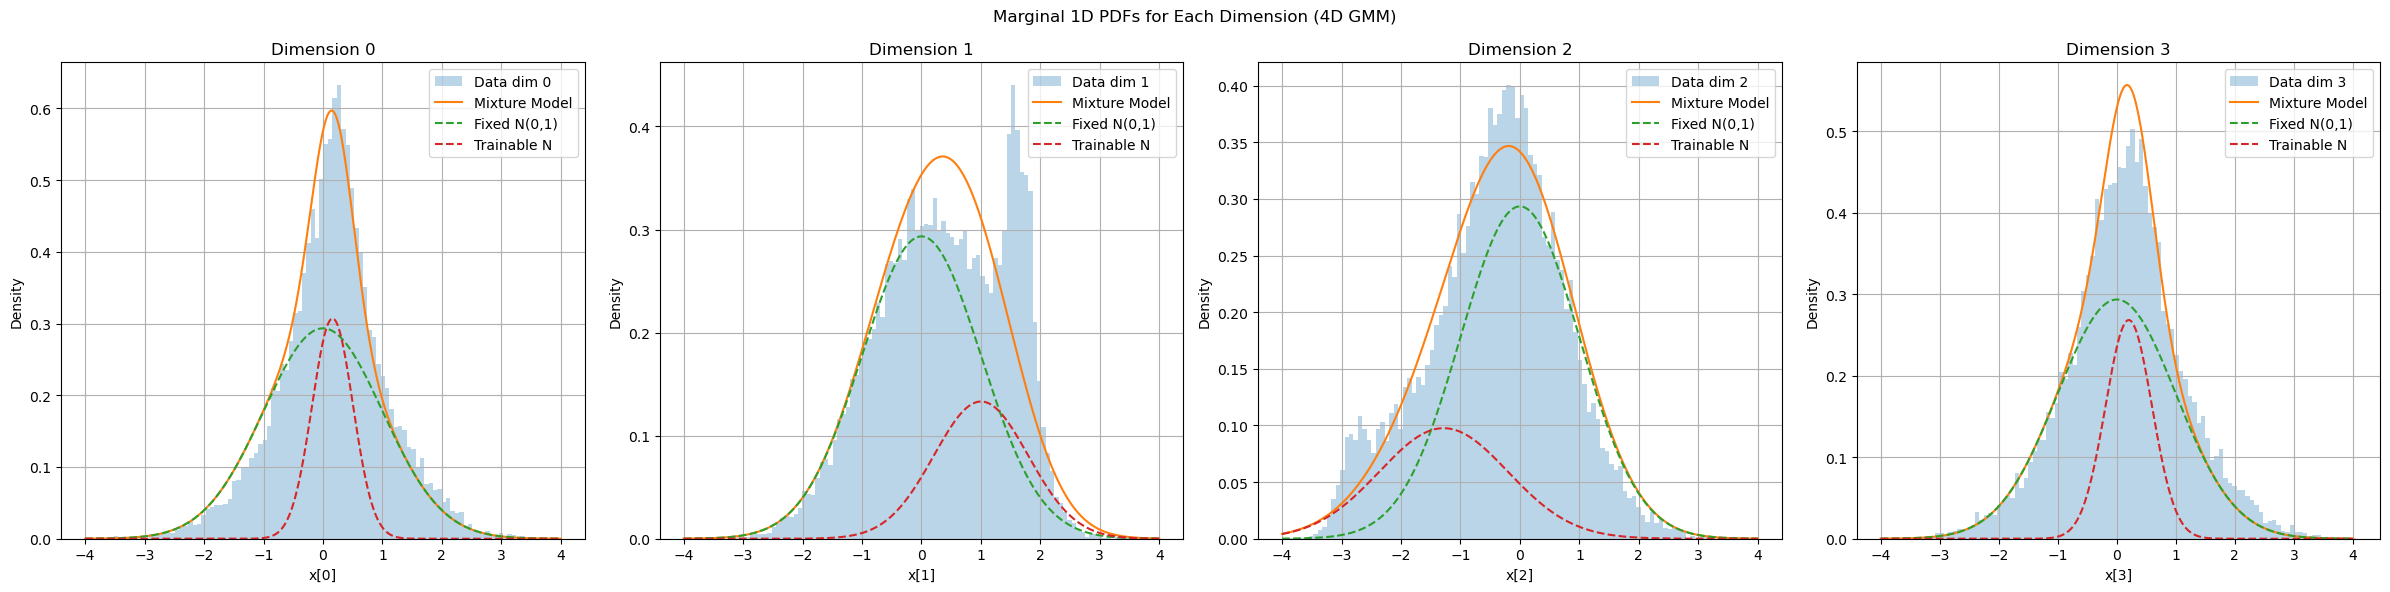

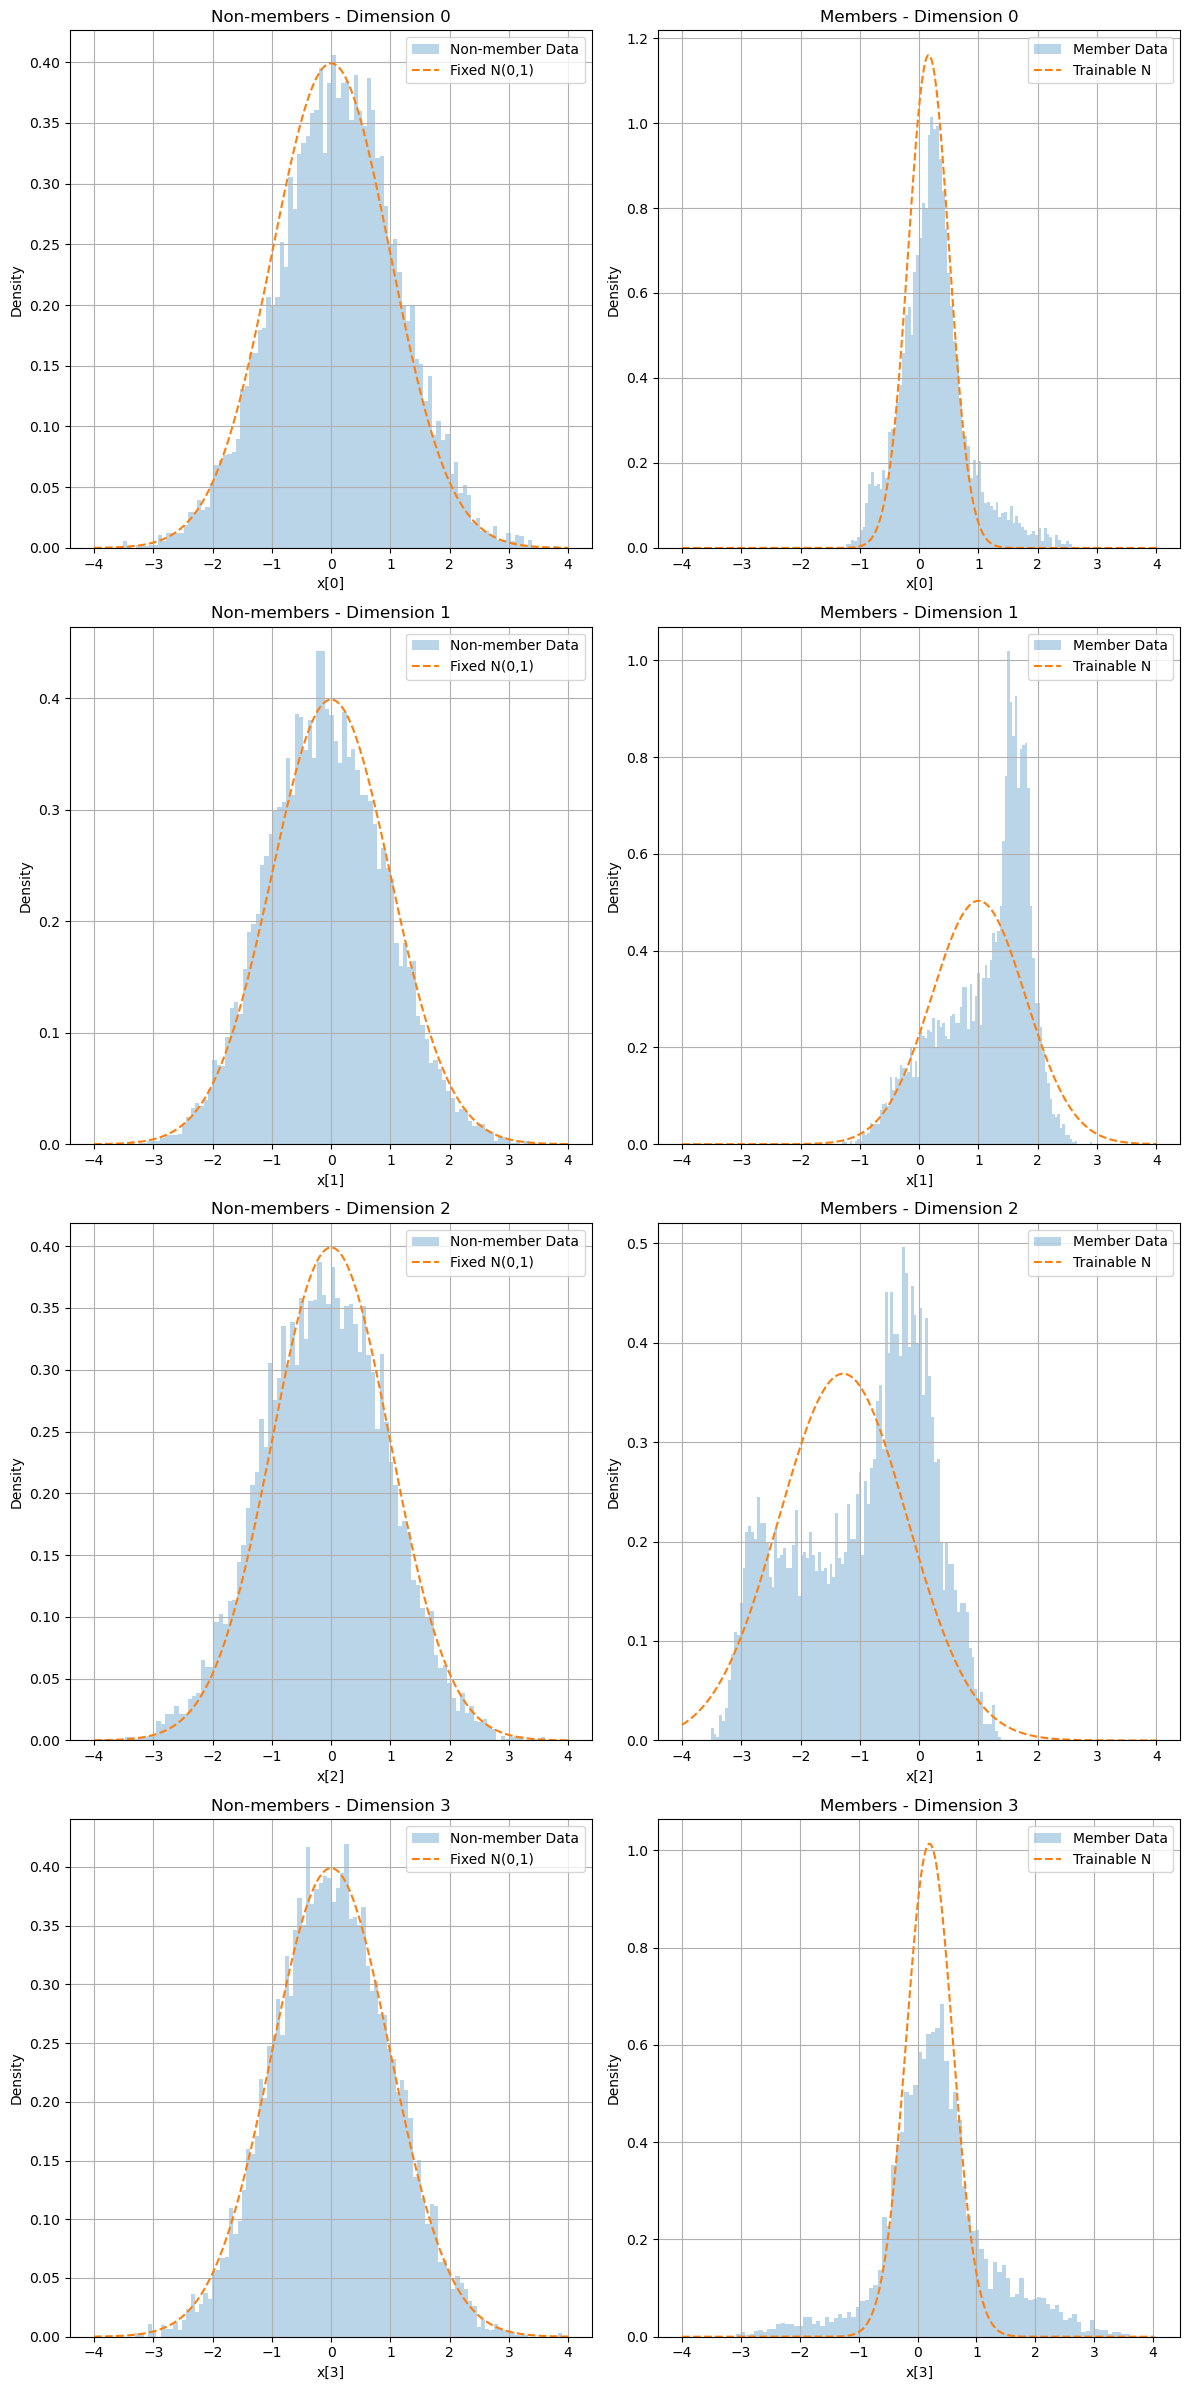

Logits: [0.7353342 0.2646658]
Mu: [ 0.16087356  1.0018994  -1.2837031   0.20317434]
Sigma: [[ 0.11825267  0.17247647  0.23974483 -0.0678986 ]
 [ 0.17247647  0.62906754  0.70587385 -0.09746339]
 [ 0.23974483  0.70587385  1.1709257  -0.13237676]
 [-0.0678986  -0.09746339 -0.13237676  0.15499221]]


In [67]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler


## Let's take 4D data: PMdec
data = z_test_cut[['PMra', 'PMdec', 'BP0-RP0', 'G0_c']].values
sigma_data = z_test_cut[['pmra_error', 'pmdec_error', 'bp_rp_error', 'phot_g_mean_mag_err']].values

#error_scaler = MinMaxScaler()
#sigma_data = error_scaler.fit_transform(sigma_data.reshape(-1, 1))



# retrive the second pdf from the bimodal Gaussian
logits, mu, sigma = BimodalGaussian(data, nonmembers_indices)
print('Logits:', logits)
print('Mu:', mu)
print('Sigma:', sigma)

## Multimodal Gaussian 4D

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

def MultimodalGaussian(data, nonmembers_indices, n_trainable=10, n_steps=1000, lr=5e-2, seed=42):

    tf.random.set_seed(seed)
    np.random.seed(seed)

    #PRIOR:
    N_contaminants = len(nonmembers_indices)      # here to change with density*area
    N_stars = len(data) - N_contaminants

    Pg = N_contaminants / (N_stars + N_contaminants)
    print('Prior probability of contamination:', Pg)
    Pgal = 1 - Pg
    print('Prior probability of being a star:', Pgal)

    dim = data.shape[1]
    n_components = n_trainable + 1  # including fixed component

    # FIXED component: Multivariate N(0, I)
    fixed_loc = tf.zeros([dim], dtype=tf.float32)
    fixed_scale_diag = tf.ones([dim], dtype=tf.float32)

    # TRAINABLE components
    trainable_logits = tf.Variable(tf.random.normal([n_trainable], mean=0.0, stddev=0.1, dtype=tf.float32))   # weights for trainable components
    trainable_loc = tf.Variable(tf.random.normal([n_trainable, dim],  mean=0.2, stddev=0.1), dtype=tf.float32) # means for trainable components
    trainable_scale_unconstrained = tf.Variable(tf.random.normal([n_trainable, dim], stddev=0.1), dtype=tf.float32) # "sigma" for trainable components

    softplus = tfb.Softplus()

    # Combine all components
    def mixture_model():

        # Categorical logits (1 fixed + n_trainable trainable) - weights
        trainable_weights = tf.nn.softmax(trainable_logits) * Pgal      # [n_trainable]
        mixing_weights = tf.concat([tf.constant([Pg], dtype=tf.float32), trainable_weights], axis=0)  # [fixed component]+[n_components]

        # Concatenate fixed + trainable means and scales
        all_loc = tf.concat([tf.expand_dims(fixed_loc, axis=0), trainable_loc], axis=0)              # [11, 4]
        all_scale_diag = tf.concat([tf.expand_dims(fixed_scale_diag, axis=0), 
                                    softplus(trainable_scale_unconstrained)], axis=0)                 # [11, 4]

        components = tfd.MultivariateNormalDiag(loc=all_loc, scale_diag=all_scale_diag)
        cat = tfd.Categorical(probs=mixing_weights)
        return tfd.MixtureSameFamily(mixture_distribution=cat, components_distribution=components)
    
    # Loss
    def nll():
        return -tf.reduce_mean(mixture_model().log_prob(data))
    

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)


    # Training
    variables = [trainable_loc, trainable_scale_unconstrained, trainable_logits]

    for step in range(n_steps):
        with tf.GradientTape() as tape:
            loss = nll()
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))
        if step % 50 == 0:
            print(f"Step {step}: NLL = {loss.numpy():.4f}")



    # PLOT RESULTS
    x_range = np.linspace(-4, 4, 1000, dtype=np.float32)#.reshape(-1, 1)
    
    # Retrieve weights
    trainable_logits = mixture_model().parameters["mixture_distribution"].probs_parameter()[1:].numpy()
    trainable_weights = trainable_logits / np.sum(trainable_logits)
    weights = np.concatenate([[Pg], trainable_weights * Pgal], axis=0)

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    for i in range(4): #i-th component
        ax = axes[i]

        pdf_total = weights[0] * tfd.Normal(0.0, 1.0).prob(x_range)
        for k in range(1, n_components):  # loop over all components
            mu = mixture_model().components_distribution.loc[k, i].numpy()
            sigma = mixture_model().components_distribution.scale.diag_part()[k, i].numpy()

            pdf_total += weights[k] * tfd.Normal(mu, sigma).prob(x_range)

        ax.hist(data[:, i], bins=100, density=True, alpha=0.3, label=f'Data dim {i}')
        ax.plot(x_range, pdf_total, label='Mixture Model')
        ax.plot(x_range, weights[0] * tfd.Normal(0.0, 1.0).prob(x_range), '--', label='Fixed N(0,1)')
        for k in range(1, n_components):  # loop over all components
            mu = mixture_model().components_distribution.loc[k, i].numpy()
            sigma = mixture_model().components_distribution.scale.diag_part()[k, i].numpy()
            ax.plot(x_range, weights[k] * tfd.Normal(mu, sigma).prob(x_range), '--', label=f'Trainable {k}')

        ax.set_title(f"Dimension {i+1}")
        ax.set_xlabel(f"x[{i+1}]")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True)

    plt.suptitle("Marginal 1D PDFs for Each Dimension (4D GMM)")
    plt.tight_layout()
    plt.show()
    

    # check if the two gaussian found fir the data
    fig, axes = plt.subplots(4, 2, figsize=(12, 24))  # 4 rows x 2 columns
    complex_distributions_dict = {}
    for i in range(4):

        # Non-members (left column)
        ax_left = axes[i, 0]
        ax_left.hist(data[nonmembers_indices, i], bins=100, density=True, alpha=0.3, label='Non-member Data')
        ax_left.plot(x_range, tfd.Normal(0.0, 1.0).prob(x_range), '--', label='Fixed N(0,1)')
        ax_left.set_xlabel(f"x[{i+1}]")
        ax_left.set_ylabel("Density")
        ax_left.set_title(f"Non-members - Dimension {i+1}")
        ax_left.grid(True)
        ax_left.legend()

        # Members (right column)
        ax_right = axes[i, 1]
        ax_right.hist(data[members_indices, i], bins=100, density=True, alpha=0.3, label='Member Data')

        members_dist = np.zeros_like(x_range, dtype=np.float32)
        for k in range(1, n_components):  # loop over all components
            mu = mixture_model().components_distribution.loc[k, i].numpy()
            sigma = mixture_model().components_distribution.scale.diag_part()[k, i].numpy()
            members_dist += weights[k] * tfd.Normal(mu, sigma).prob(x_range)
        members_dist = members_dist / np.sum(weights[1:])  # Normalize to ensure it sums to 1
        ax_right.plot(x_range, members_dist, '--', label='Trainable')
        ax_right.set_xlabel(f"x[{i+1}]")
        ax_right.set_ylabel("Density")
        ax_right.set_title(f"Members - Dimension {i+1}")
        ax_right.grid(True)
        ax_right.legend()

    plt.tight_layout()
    plt.show()

    # Return the parameters: all weights, means, and covariance matrices
    return weights, mixture_model().components_distribution.loc.numpy(), mixture_model().components_distribution.scale.diag_part().numpy()  


Prior probability of contamination: 0.6111859013584628
Prior probability of being a star: 0.38881409864153715
Step 0: NLL = 6.0725
Step 50: NLL = 5.3321
Step 100: NLL = 5.1167
Step 150: NLL = 5.0838
Step 200: NLL = 5.0669
Step 250: NLL = 5.0610


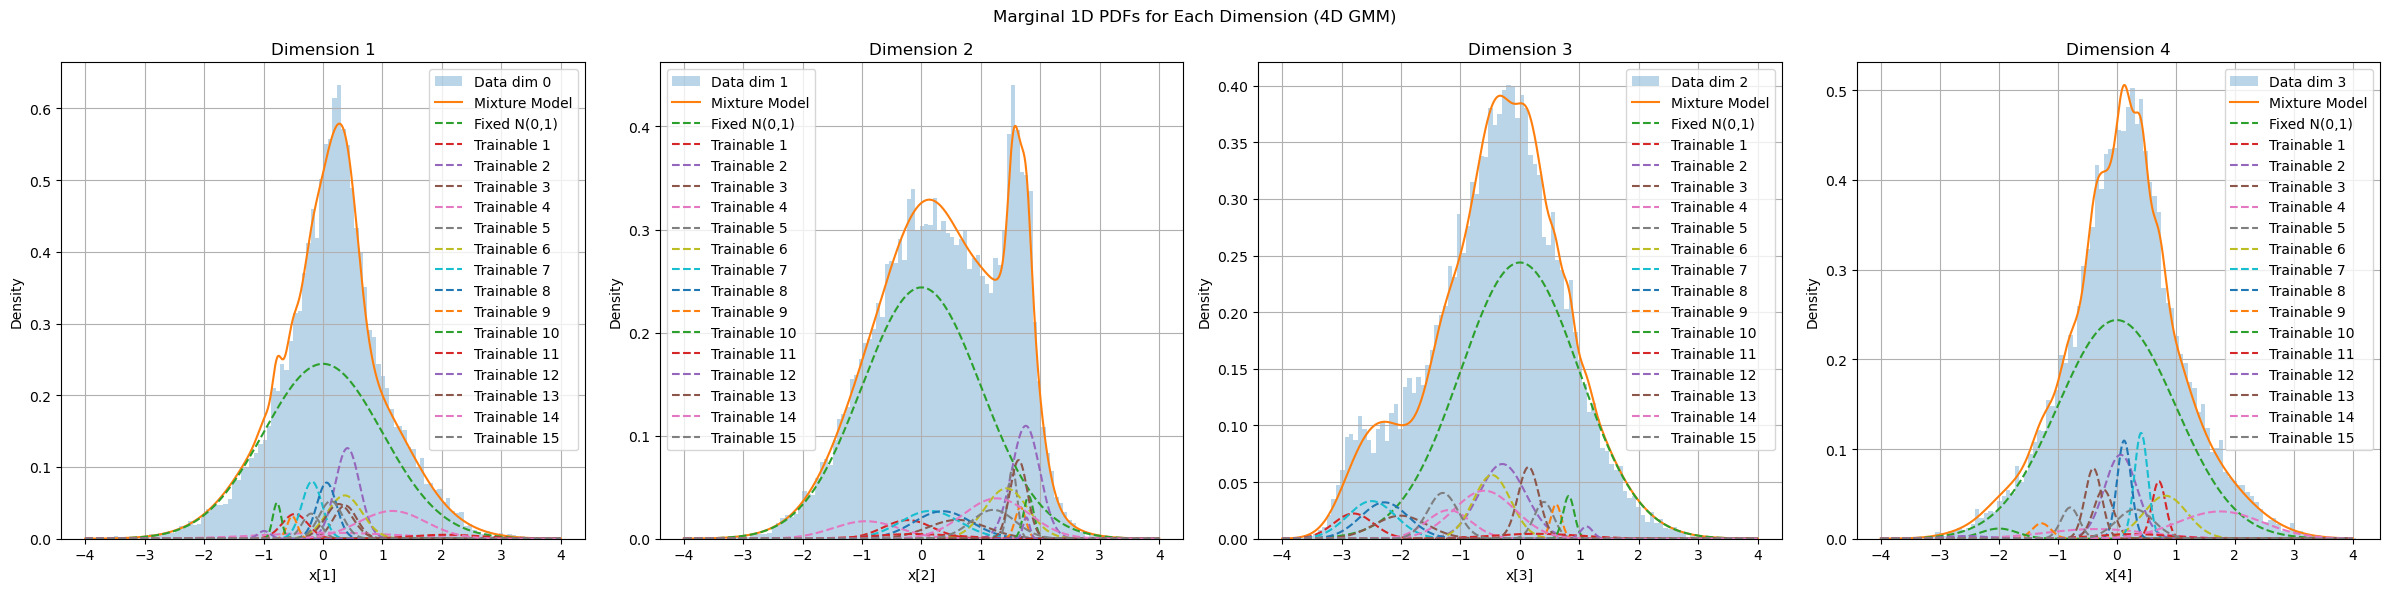

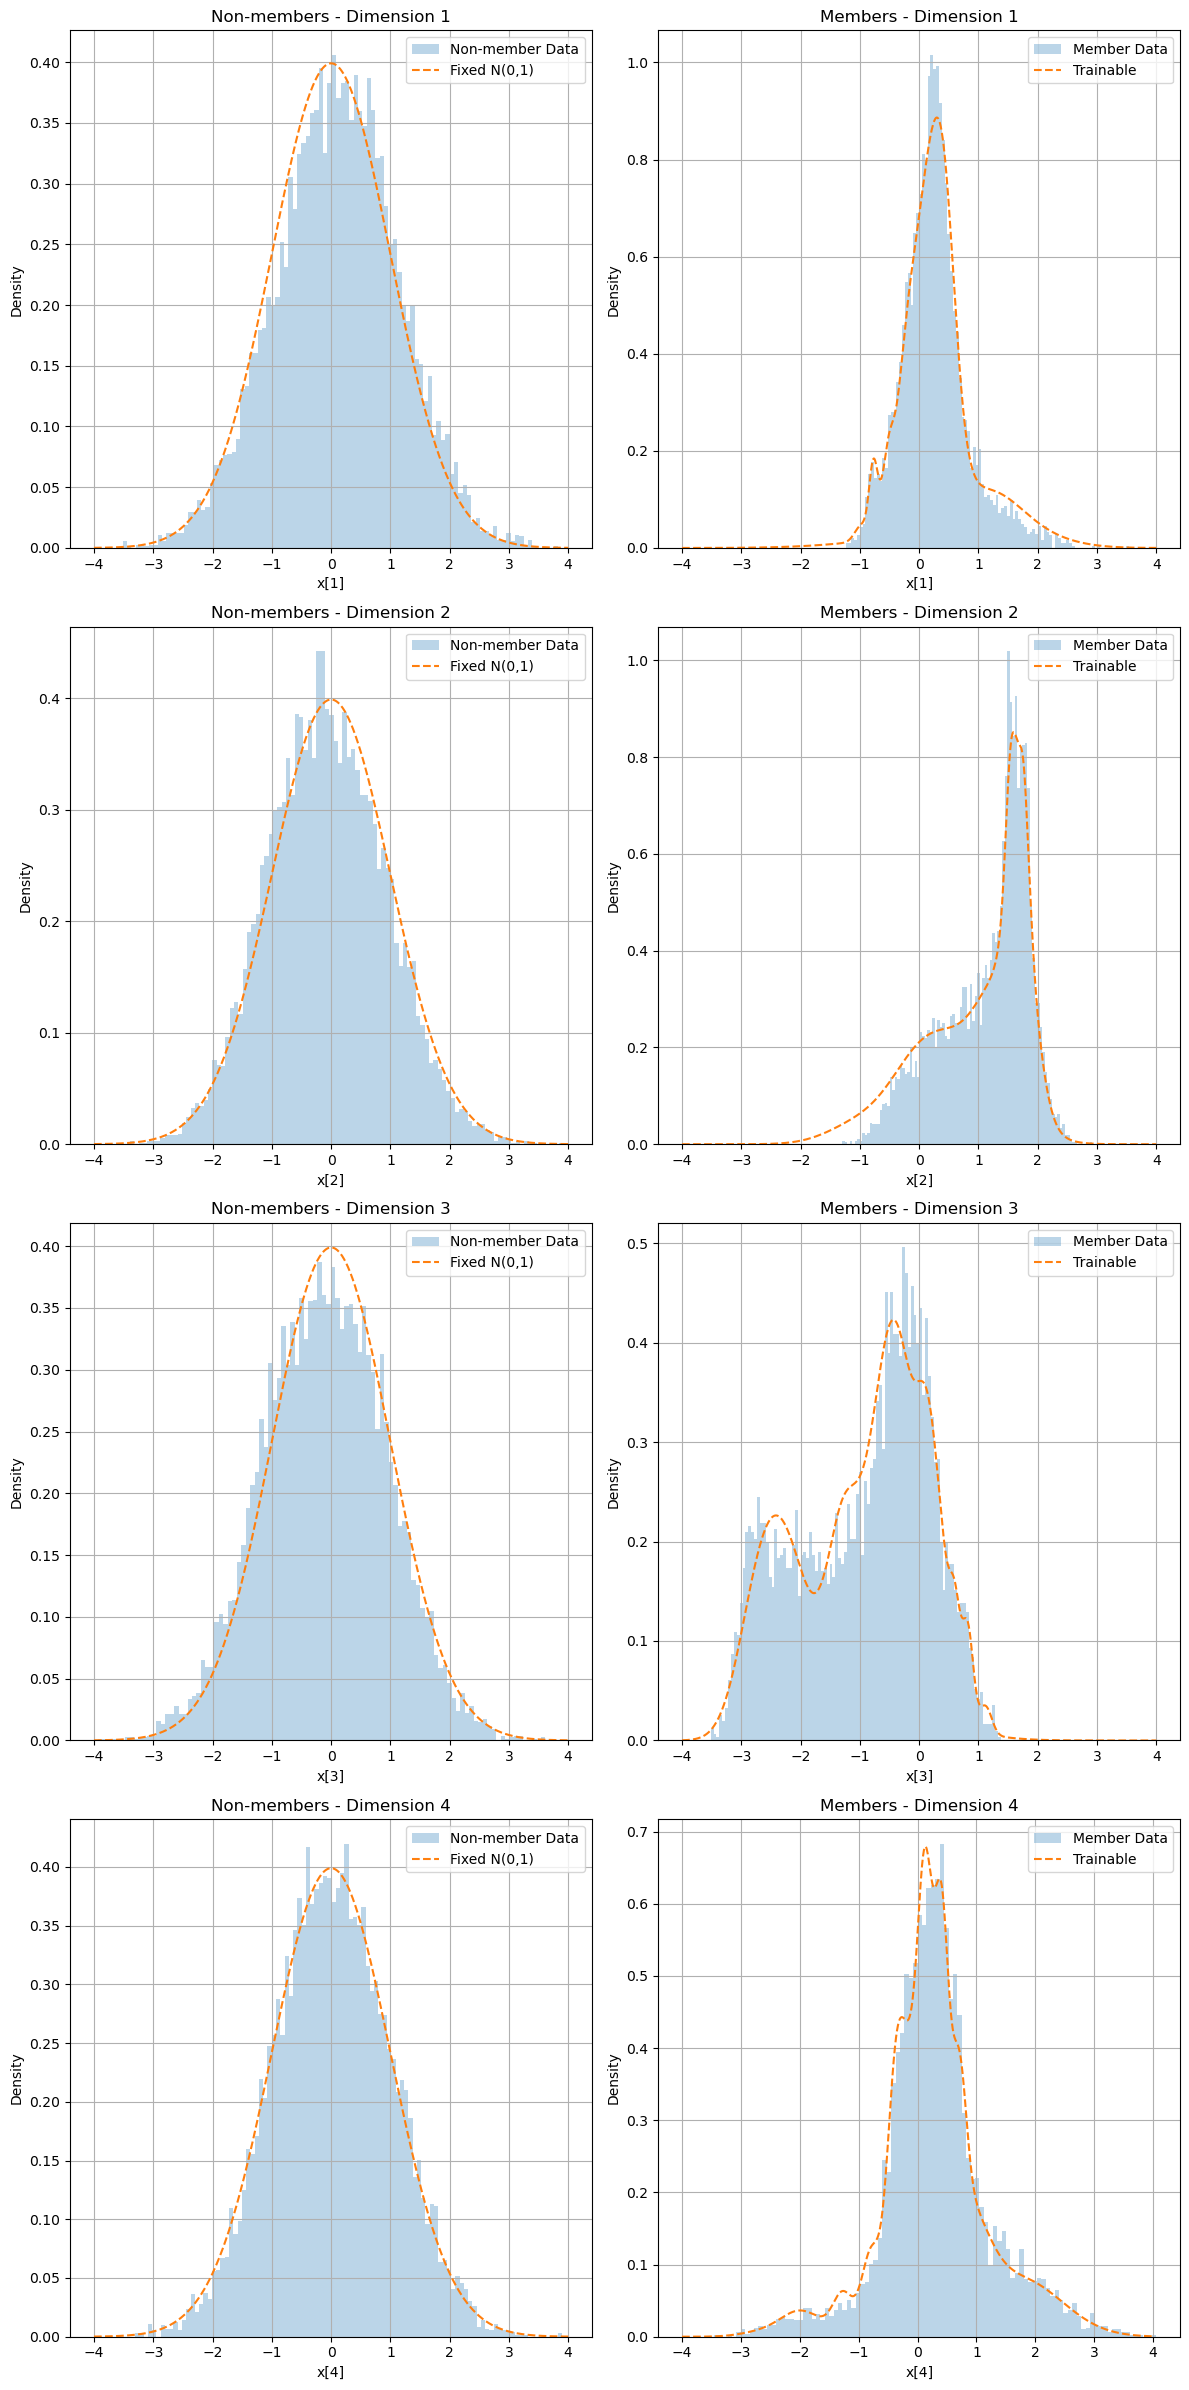

Logits: [0.6111859  0.01875432 0.06482331 0.0226818  0.02359116 0.0133119
 0.04416178 0.03375179 0.03238928 0.00683379 0.00891103 0.008167
 0.00282487 0.02790281 0.05471574 0.0259935 ]
Mu: [[ 0.          0.          0.          0.        ]
 [-0.47214445 -0.23049158 -2.8003745   0.71256185]
 [ 0.41102716  1.7549362  -0.29538834  0.06624174]
 [ 0.37270007  0.6040074  -2.0064206  -0.22562791]
 [ 0.11675954 -0.93541354 -1.1980569  -0.347669  ]
 [-0.19981804  1.5305964   0.40225887 -0.7888318 ]
 [ 0.36463502  1.4277881  -0.46979344  0.8243812 ]
 [-0.18589847  0.1465188  -2.4950078   0.412417  ]
 [ 0.06076885  0.3567033  -2.2778313   0.12464584]
 [-0.5179667   1.6641359   0.6080498  -1.2752357 ]
 [-0.77365506  1.8031368   0.82021    -1.9949458 ]
 [ 2.0760417  -0.11676167  0.26795334  0.27519757]
 [-0.9907415   1.7633893   1.1202435  -2.5553834 ]
 [ 0.26677293  1.6342394   0.14435771 -0.39658022]
 [ 1.1660973   1.2640076  -0.59856284  1.7508605 ]
 [ 0.13206516  1.2077569  -1.2966992   0.30854

In [15]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler


## Let's take 4D data: PMdec
data = z_test_cut[['PMra', 'PMdec', 'BP0-RP0', 'G0_c']].values
sigma_data = z_test_cut[['pmra_error', 'pmdec_error', 'bp_rp_error', 'phot_g_mean_mag_err']].values

#error_scaler = MinMaxScaler()
#sigma_data = error_scaler.fit_transform(sigma_data.reshape(-1, 1))



# retrive the TOTAL pdf from the bimodal Gaussian
logits, mu, sigma = MultimodalGaussian(data, nonmembers_indices, n_steps=300, lr=0.05, n_trainable=15)
print('Logits:', logits)
print('Mu:', mu)
print('Sigma:', sigma)

In [16]:
# Build the complex distribution
def build_complex_distribution(logits, mu, sigma):
    # Convert everything to float32 for consistency
    logits = tf.convert_to_tensor(logits[1:], dtype=tf.float32)
    mu = tf.convert_to_tensor(mu[1:], dtype=tf.float32)
    sigma = tf.convert_to_tensor(sigma[1:], dtype=tf.float32)
    
    # Components
    components = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    # Mixture weights
    cat = tfd.Categorical(probs=logits)  # already float32
    return tfd.MixtureSameFamily(mixture_distribution=cat, components_distribution=components)

    
def p_z_given_rest(N_S, N_B, alpha, label):
    # Compute p(z_i = S/B | z_{-i}) using Eq. (15) from the paper.
    if label == 'S':
        return np.float32((N_S + alpha) / (N_S + N_B + 2 * alpha))
    else:
        return np.float32((N_B + alpha) / (N_S + N_B + 2 * alpha))


In [17]:
@tf.function
def compute_posteriors(likelihood_S, likelihood_B, p_S_prior, p_B_prior):
    p_S = likelihood_S * p_S_prior
    p_B = likelihood_B * p_B_prior
    norm = p_S + p_B
    return p_S / norm, p_B / norm

In [18]:
from scipy.stats import truncnorm

def sample_positive_normal(loc, scale, size):
    a, b = (0 - loc) / scale, np.inf  # lower bound 0, upper inf
    return truncnorm.rvs(a, b, loc=loc, scale=scale, size=size)


## Gibbs sampling for model selection

n_iterations = 10

# Initialize latent labels based on number of stars and binaries
N = len(data)
alpha = 2.0

# Initialize latent labels randomly
S_label = ['S']*int(len(data)/2)
B_label = ['B']*int(len(data)/2)

print('Number of stars:', len(S_label))
print('Number of binaries:', len(B_label))

z = np.array(S_label + B_label)
# Shuffle the labels
np.random.shuffle(z)
#z = np.random.choice(['S', 'B'], size=N)
trace_z = []
members_prob = []
contamints_prob = []


# Build the Known and unknown PDF using the trained weights
fixed_mu = np.zeros(4, dtype=np.float32)
fixed_sigma = np.ones(4, dtype=np.float32)
contaminants_dist = tfd.MultivariateNormalDiag(loc=fixed_mu, scale_diag=fixed_sigma)
members_dist = build_complex_distribution(logits, mu, sigma)

data_tf = tf.convert_to_tensor(data, dtype=tf.float32)

likelihood_S_all = contaminants_dist.prob(data_tf)  # shape (N,)
likelihood_B_all = members_dist.prob(data_tf)       # shape (N,)

for it in tqdm(range(n_iterations), desc='iteration'):
    pS = np.zeros(N, dtype=np.float32)
    pB = np.zeros(N, dtype=np.float32)
    for i in range(N):
        # Count excluding current
        z_minus = np.delete(z, i)
        N_S = np.sum(z_minus == 'S')
        N_B = N - 1 - N_S
                
        # Prior p(z_i = S/B | z_{-i})
        p_S_prior = p_z_given_rest(N_S, N_B, alpha, 'S')
        p_B_prior = p_z_given_rest(N_S, N_B, alpha, 'B')


        # Likelihoods
        likelihood_S = likelihood_S_all[i]
        likelihood_B = likelihood_B_all[i]

        # Posterior
        p_S, p_B = compute_posteriors(likelihood_S, likelihood_B, p_S_prior, p_B_prior)

        pS[i] = p_S
        pB[i] = p_B
        
        if p_S > p_B:
            z[i] = 'S'
        else:
            z[i] = 'B'

    trace_z.append(z.copy())
    members_prob.append(pS)
    contamints_prob.append(pB)

# Estimate posterior probabilities over samples
trace_z_array = np.array(trace_z)
members_prob_array = np.array(members_prob)
contaminants_prob_array = np.array(contamints_prob)
posterior_z_prob = np.mean(trace_z_array == 'S', axis=0)

posterior_z_prob[:10]

Number of stars: 8171
Number of binaries: 8171


iteration:   0%|          | 0/10 [00:00<?, ?it/s]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
z_test_BMG1 = z_test_cut.copy()

z_test_BMG1['posterior_prob'] = posterior_z_prob

z_test_BMG1.head(10)

,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,pmra_pmdec_corr,phot_g_mean_mag_err,phot_bp_mean_mag_err,posterior_prob
0,42,0.506135,0.511146,-0.270796,1.489784,0.235262,-0.643772,0.046005,0.047857,0.306743,-0.367,0.011499,0.021656,0.0
1,42,0.492262,0.507918,-0.270781,1.462612,0.251180,-0.749792,0.044330,0.050151,0.306636,-0.367,0.010303,0.021047,0.0
2,42,0.513604,0.516493,0.660488,2.113044,0.228475,-0.173899,0.127675,0.116830,0.317555,-0.367,0.057223,0.059695,0.0
3,42,0.525653,0.504465,0.165351,1.523946,-0.620829,0.442608,0.154806,0.133301,0.318696,-0.367,0.076125,0.073138,0.0
4,42,0.513119,0.482172,-0.150709,-0.200669,-3.361919,0.777049,0.234914,0.229835,0.295862,-0.367,0.128198,0.077367,0.0
5,42,0.510959,0.484975,-0.128260,0.419755,-2.548569,0.105383,0.184795,0.180621,0.306719,-0.367,0.095646,0.070429,0.0
6,42,0.484713,0.484182,0.387454,0.724758,-0.527082,1.358850,0.255682,0.232585,0.328107,-0.367,0.167787,0.111957,0.0
7,42,0.496355,0.496788,1.159776,2.006936,-0.244338,1.707817,0.353029,0.315988,0.337422,-0.367,0.211896,0.128893,0.0
8,42,0.512108,0.502989,-0.063661,-0.476118,-2.920482,0.626166,0.232461,0.203632,0.303406,-0.367,0.125362,0.077554,0.0
9,42,0.498932,0.502919,0.443186,1.804623,-0.329854,-0.169984,0.101847,0.103997,0.313854,-0.367,0.045378,0.049607,0.0


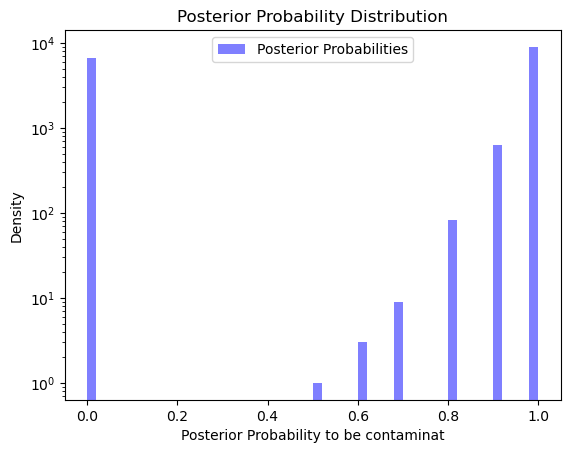

In [28]:
plt.hist(z_test_BMG1['posterior_prob'].values, bins=50, density=False, alpha=0.5, color='blue', label='Posterior Probabilities')
plt.xlabel('Posterior Probability to be contaminat')
plt.ylabel('Density')
plt.yscale('log')
plt.title('Posterior Probability Distribution')
plt.legend(loc='upper center')

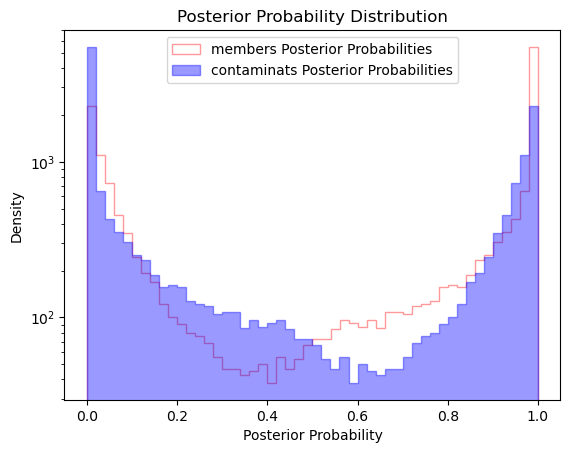

In [27]:
plt.hist(members_prob_array[-1], bins=50, density=False, alpha=0.4, fill=False, histtype='step', color='red', label='members Posterior Probabilities')
plt.hist(contaminants_prob_array[-1], bins=50, density=False, alpha=0.4, fill=True, histtype='step', color='blue', label='contaminats Posterior Probabilities')
plt.xlabel('Posterior Probability')
plt.ylabel('Density')
plt.yscale('log')
plt.title('Posterior Probability Distribution')
plt.legend(loc='upper center')

In [21]:
z_test_BMG1.head(30)

,source_id,Xi,Xn,PMra,PMdec,BP0-RP0,G0_c,pmra_error,pmdec_error,bp_rp_error,pmra_pmdec_corr,phot_g_mean_mag_err,phot_bp_mean_mag_err,posterior_prob
0,42,0.506135,0.511146,-0.270796,1.489784,0.235262,-0.643772,0.046005,0.047857,0.306743,-0.367,0.011499,0.021656,0.0
1,42,0.492262,0.507918,-0.270781,1.462612,0.251180,-0.749792,0.044330,0.050151,0.306636,-0.367,0.010303,0.021047,0.0
2,42,0.513604,0.516493,0.660488,2.113044,0.228475,-0.173899,0.127675,0.116830,0.317555,-0.367,0.057223,0.059695,0.0
3,42,0.525653,0.504465,0.165351,1.523946,-0.620829,0.442608,0.154806,0.133301,0.318696,-0.367,0.076125,0.073138,0.0
4,42,0.513119,0.482172,-0.150709,-0.200669,-3.361919,0.777049,0.234914,0.229835,0.295862,-0.367,0.128198,0.077367,0.0
5,42,0.510959,0.484975,-0.128260,0.419755,-2.548569,0.105383,0.184795,0.180621,0.306719,-0.367,0.095646,0.070429,0.0
6,42,0.484713,0.484182,0.387454,0.724758,-0.527082,1.358850,0.255682,0.232585,0.328107,-0.367,0.167787,0.111957,0.0
7,42,0.496355,0.496788,1.159776,2.006936,-0.244338,1.707817,0.353029,0.315988,0.337422,-0.367,0.211896,0.128893,0.0
8,42,0.512108,0.502989,-0.063661,-0.476118,-2.920482,0.626166,0.232461,0.203632,0.303406,-0.367,0.125362,0.077554,0.0
9,42,0.498932,0.502919,0.443186,1.804623,-0.329854,-0.169984,0.101847,0.103997,0.313854,-0.367,0.045378,0.049607,0.0


In [22]:
print('number of non members: ', len(nonmembers_indices))
print('number of members: ', len(members_indices))
print('')
print(f"TN posterior prob > 0.5: {np.sum(z_test_BMG1.iloc[nonmembers_indices]['posterior_prob'] > 0.5)}")
print(f"TP posterior prob < 0.5: {np.sum(z_test_BMG1.iloc[members_indices]['posterior_prob'] < 0.5)}")
print(f"FP posterior prob < 0.5: {np.sum(z_test_BMG1.iloc[nonmembers_indices]['posterior_prob'] < 0.5)}")
print(f"FN posterior prob > 0.5: {np.sum(z_test_BMG1.iloc[members_indices]['posterior_prob'] > 0.5)}")
print('')
print(f"TN posterior prob > 0.95: {np.sum(z_test_BMG1.iloc[nonmembers_indices]['posterior_prob'] > 0.95)}")
print(f"TP posterior prob < 0.02: {np.sum(z_test_BMG1.iloc[members_indices]['posterior_prob'] < 0.02)}")
print(f"FP posterior prob < 0.02: {np.sum(z_test_BMG1.iloc[nonmembers_indices]['posterior_prob'] < 0.02)}")
print(f"FN posterior prob > 0.95: {np.sum(z_test_BMG1.iloc[members_indices]['posterior_prob'] > 0.95)}")

number of non members:  9988
number of members:  6354

TN posterior prob > 0.5: 9395
TP posterior prob < 0.5: 6019
FP posterior prob < 0.5: 592
FN posterior prob > 0.5: 335

TN posterior prob > 0.95: 8806
TP posterior prob < 0.02: 6019
FP posterior prob < 0.02: 592
FN posterior prob > 0.95: 198


In [23]:
def confusion_matrix(df, members_indices, nonmembers_indices, members_threshold=0.5, nonmembers_threshold=0.5):
    TP = np.where((df['source_id']==42) & (df['posterior_prob'] < members_threshold))[0]
    TN = np.where((df['source_id']!=42) & (df['posterior_prob'] > nonmembers_threshold))[0]
    FP = np.where((df['source_id']!=42) & (df['posterior_prob'] < members_threshold))[0]
    FN = np.where((df['source_id']==42) & (df['posterior_prob'] > nonmembers_threshold))[0]

    return TP, TN, FP, FN

TP, TN, FP, FN = confusion_matrix(z_test_BMG1, members_indices, nonmembers_indices, members_threshold=0.02, nonmembers_threshold=0.95)

In [24]:
def confusion_plots_latex(df, TP, FP, FN, TN, members, non_members):

    print('TP: ', len(TP))
    print('FP: ', len(FP))
    print('FN: ', len(FN))
    print('TN: ', len(TN))
  

    confusion_dict = {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    fig, ax = plt.subplots(4, 3, figsize=(15, 20))
    #fig.suptitle(f'Confusion plots UMAP: thresholds {memb_thr} - {nonmemb_thr}; members={members.shape[0]} non members={non_members.shape[0]}', fontsize=20)
    for i in range(4):

        if confusion_type[i] == 'TP' or confusion_type[i] == 'FN':
            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

        else:

            ax[i, 0].scatter(df['Xi'], df['Xn'], s=5, alpha=0.3, c='grey')
            ax[i, 0].scatter(df.loc[confusion_dict[confusion_type[i]], ['Xi']], df.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                             label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(non_members)*100:.2f}%')
            ax[i, 0].set_xlabel('Xi')
            ax[i, 0].set_ylabel('Xn')
            ax[i, 0].legend(loc='upper left')

            ax[i, 1].scatter(df['PMra'], df['PMdec'], s=5, alpha=0.3, c='grey')
            ax[i, 1].scatter(df.loc[confusion_dict[confusion_type[i]], ['PMra']], df.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
            ax[i, 1].set_xlabel('pmra')
            ax[i, 1].set_ylabel('pmdec')

            ax[i, 2].scatter(df['BP0-RP0'], df['G0_c'], s=5, alpha=0.3, c='grey')
            ax[i, 2].scatter(df.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], df.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
            ax[i, 2].invert_yaxis()
            ax[i, 2].set_xlabel('BP0-RP0')
            ax[i, 2].set_ylabel('G0_c')

    #plt.tight_layout()
    #plt.show()

    return fig


TP:  6019
FP:  592
FN:  198
TN:  8806


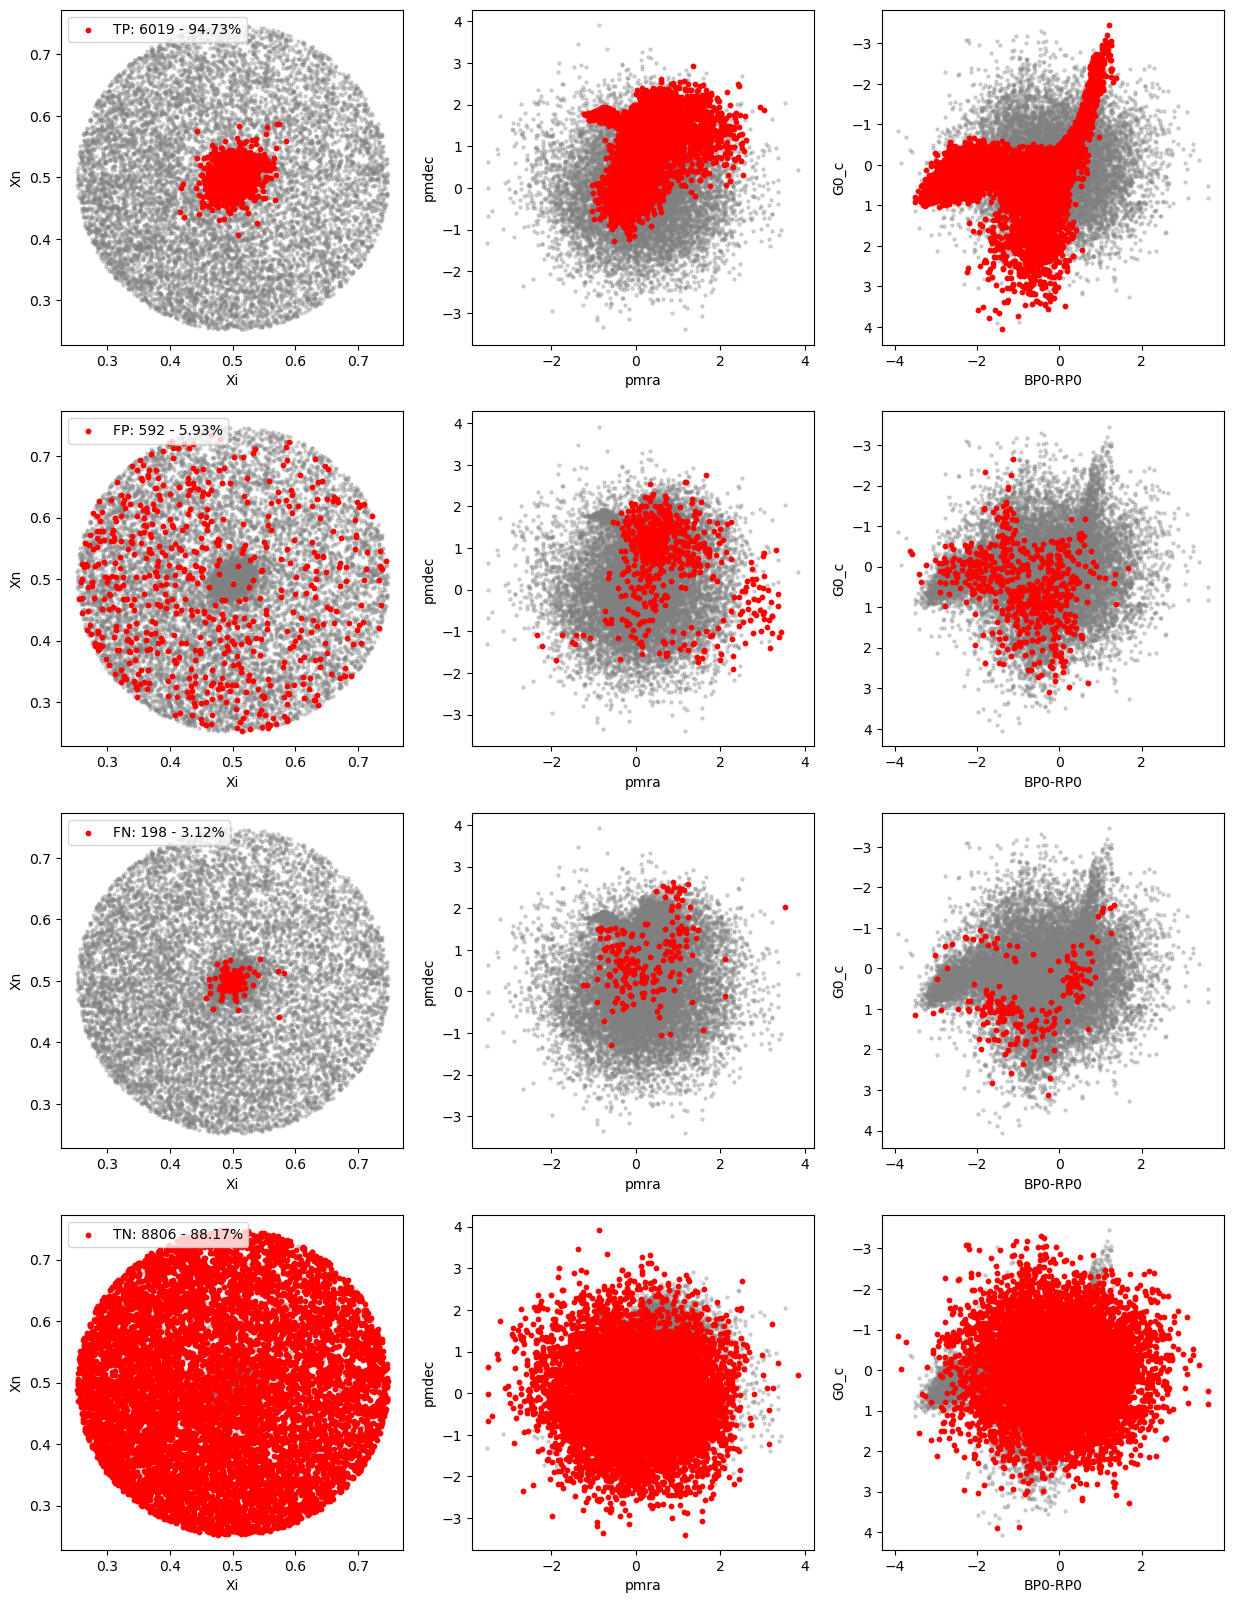

In [25]:
fig = confusion_plots_latex(z_test_BMG1, TP, FP, FN, TN, members_indices, nonmembers_indices)